# Frontier Peptide Atlas - Figure Generation

**Author:** Agna Chan  
**Purpose:** Generate all figures for the research paper  
**Output:** `figures/` directory with publication-ready PNG/PDF files

---

## DISCLAIMER

This notebook is for RESEARCH AND EDUCATIONAL PURPOSES ONLY.  
No medical advice, dosing, or protocol recommendations are provided.

## Setup

In [1]:
import sys
import os
from pathlib import Path

# Add src to path (notebook is in project root)
sys.path.insert(0, 'src')

# Create figures directory in outputs
FIGURES_DIR = Path('outputs/figures')
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"Figures will be saved to: {FIGURES_DIR.absolute()}")

Figures will be saved to: /Users/agnac/Documents/quantivida/qv-rnd/frontier-pep/peptide-atlas/outputs/figures


In [2]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns

# Scikit-learn
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import LabelEncoder

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9

# Color palette for mechanism classes (matching constants.py)
CLASS_COLORS = {
    'ghrh_analog': '#1f77b4',
    'ghs_ghrelin_mimetic': '#2ca02c',
    'igf_axis': '#ff7f0e',
    'regenerative_repair': '#d62728',
    'thymic_immune': '#9467bd',
    'metabolic_incretin': '#8c564b',
    'cns_neurotrophic': '#e377c2',
    'longevity_cellular': '#17becf',
    'antimicrobial': '#BB8FCE',
    'glp1_reference': '#7f7f7f',
    'other': '#bcbd22',
}

# Pretty names for display
CLASS_NAMES = {
    'ghrh_analog': 'GHRH Analogs',
    'ghs_ghrelin_mimetic': 'GH Secretagogues',
    'igf_axis': 'IGF-1 Axis',
    'regenerative_repair': 'Regenerative/Repair',
    'thymic_immune': 'Thymic/Immune',
    'metabolic_incretin': 'Metabolic/Incretin',
    'cns_neurotrophic': 'CNS/Neurotrophic',
    'longevity_cellular': 'Longevity/Cellular',
    'antimicrobial': 'Antimicrobial',
    'glp1_reference': 'GLP-1 Reference',
    'other': 'Other',
}

print("Setup complete.")

Setup complete.


## Load Data

In [3]:
from peptide_atlas import print_disclaimer
from peptide_atlas.data.loaders import load_knowledge_graph, load_embeddings
from peptide_atlas.kg import build_knowledge_graph

print_disclaimer()

# Try to load existing KG, otherwise build it (notebook is in project root)
KG_PATH = Path('data/processed/kg.json')
EMBEDDINGS_PATH = Path('outputs/models/peptide_embeddings.npy')

if KG_PATH.exists():
    kg = load_knowledge_graph(KG_PATH)
    print(f"Loaded KG from {KG_PATH}")
else:
    kg = build_knowledge_graph()
    print("Built KG from scratch")

print(f"\nKnowledge Graph Statistics:")
print(f"  Peptides: {len(kg.peptides)}")
print(f"  Targets: {len(kg.targets)}")
print(f"  Pathways: {len(kg.pathways)}")
print(f"  Effect Domains: {len(kg.effect_domains)}")
print(f"  Risks: {len(kg.risks)}")
print(f"  Total Edges: {kg.edge_count}")

2025-12-26 11:03:38.876 | INFO     | peptide_atlas.data.loaders:load_knowledge_graph:30 - Loading knowledge graph from data/processed/kg.json


2025-12-26 11:03:38.936 | INFO     | peptide_atlas.data.loaders:load_knowledge_graph:36 - Loaded KG with 121 nodes and 424 edges



                           CRITICAL DISCLAIMER

  This Peptide Atlas is for RESEARCH AND EDUCATIONAL PURPOSES ONLY.

  - It does NOT constitute medical advice or treatment guidance.
  - Inclusion of any peptide does NOT imply safety, efficacy, or legality.
  - Many compounds are experimental, off-label, or not approved for humans.
  - NO dosing information, NO protocols, NO usage recommendations.
  - Consult a qualified healthcare professional for any medical decisions.


Loaded KG from data/processed/kg.json

Knowledge Graph Statistics:
  Peptides: 53
  Targets: 21
  Pathways: 17
  Effect Domains: 16
  Risks: 14
  Total Edges: 424


In [4]:
# Load or generate embeddings
if EMBEDDINGS_PATH.exists():
    embeddings = np.load(EMBEDDINGS_PATH)
    print(f"Loaded embeddings: {embeddings.shape}")
else:
    print("Embeddings not found. Generating random embeddings for visualization demo.")
    print("NOTE: Run train_gnn.py first for real embeddings.")
    
    # Generate structured random embeddings that cluster by class
    np.random.seed(42)
    n_peptides = len(kg.peptides)
    n_classes = 10
    embedding_dim = 64
    
    # Create class centers
    class_centers = np.random.randn(n_classes, embedding_dim) * 2
    
    # Generate embeddings around class centers
    embeddings = np.zeros((n_peptides, embedding_dim))
    class_list = list(CLASS_COLORS.keys())
    
    for i, p in enumerate(kg.peptides):
        class_idx = class_list.index(p.peptide_class.value)
        embeddings[i] = class_centers[class_idx] + np.random.randn(embedding_dim) * 0.5
    
    # L2 normalize
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    
    print(f"Generated demo embeddings: {embeddings.shape}")

# Extract peptide metadata
peptide_names = [p.canonical_name for p in kg.peptides]
peptide_classes = [p.peptide_class.value for p in kg.peptides]
evidence_tiers = [p.evidence_tier.value for p in kg.peptides]

# Encode classes numerically
le = LabelEncoder()
class_labels = le.fit_transform(peptide_classes)

print(f"\nPeptide classes: {le.classes_}")

Embeddings not found. Generating random embeddings for visualization demo.
NOTE: Run train_gnn.py first for real embeddings.
Generated demo embeddings: (53, 64)

Peptide classes: ['antimicrobial' 'cns_neurotrophic' 'ghrh_analog' 'ghs_ghrelin_mimetic'
 'glp1_reference' 'igf_axis' 'longevity_cellular' 'metabolic_incretin'
 'regenerative_repair' 'thymic_immune']


---

## Figure 1: Knowledge Graph Schema

A schematic diagram showing the 5 node types and 4 edge types.

Saved: outputs/figures/fig1_kg_schema.pdf


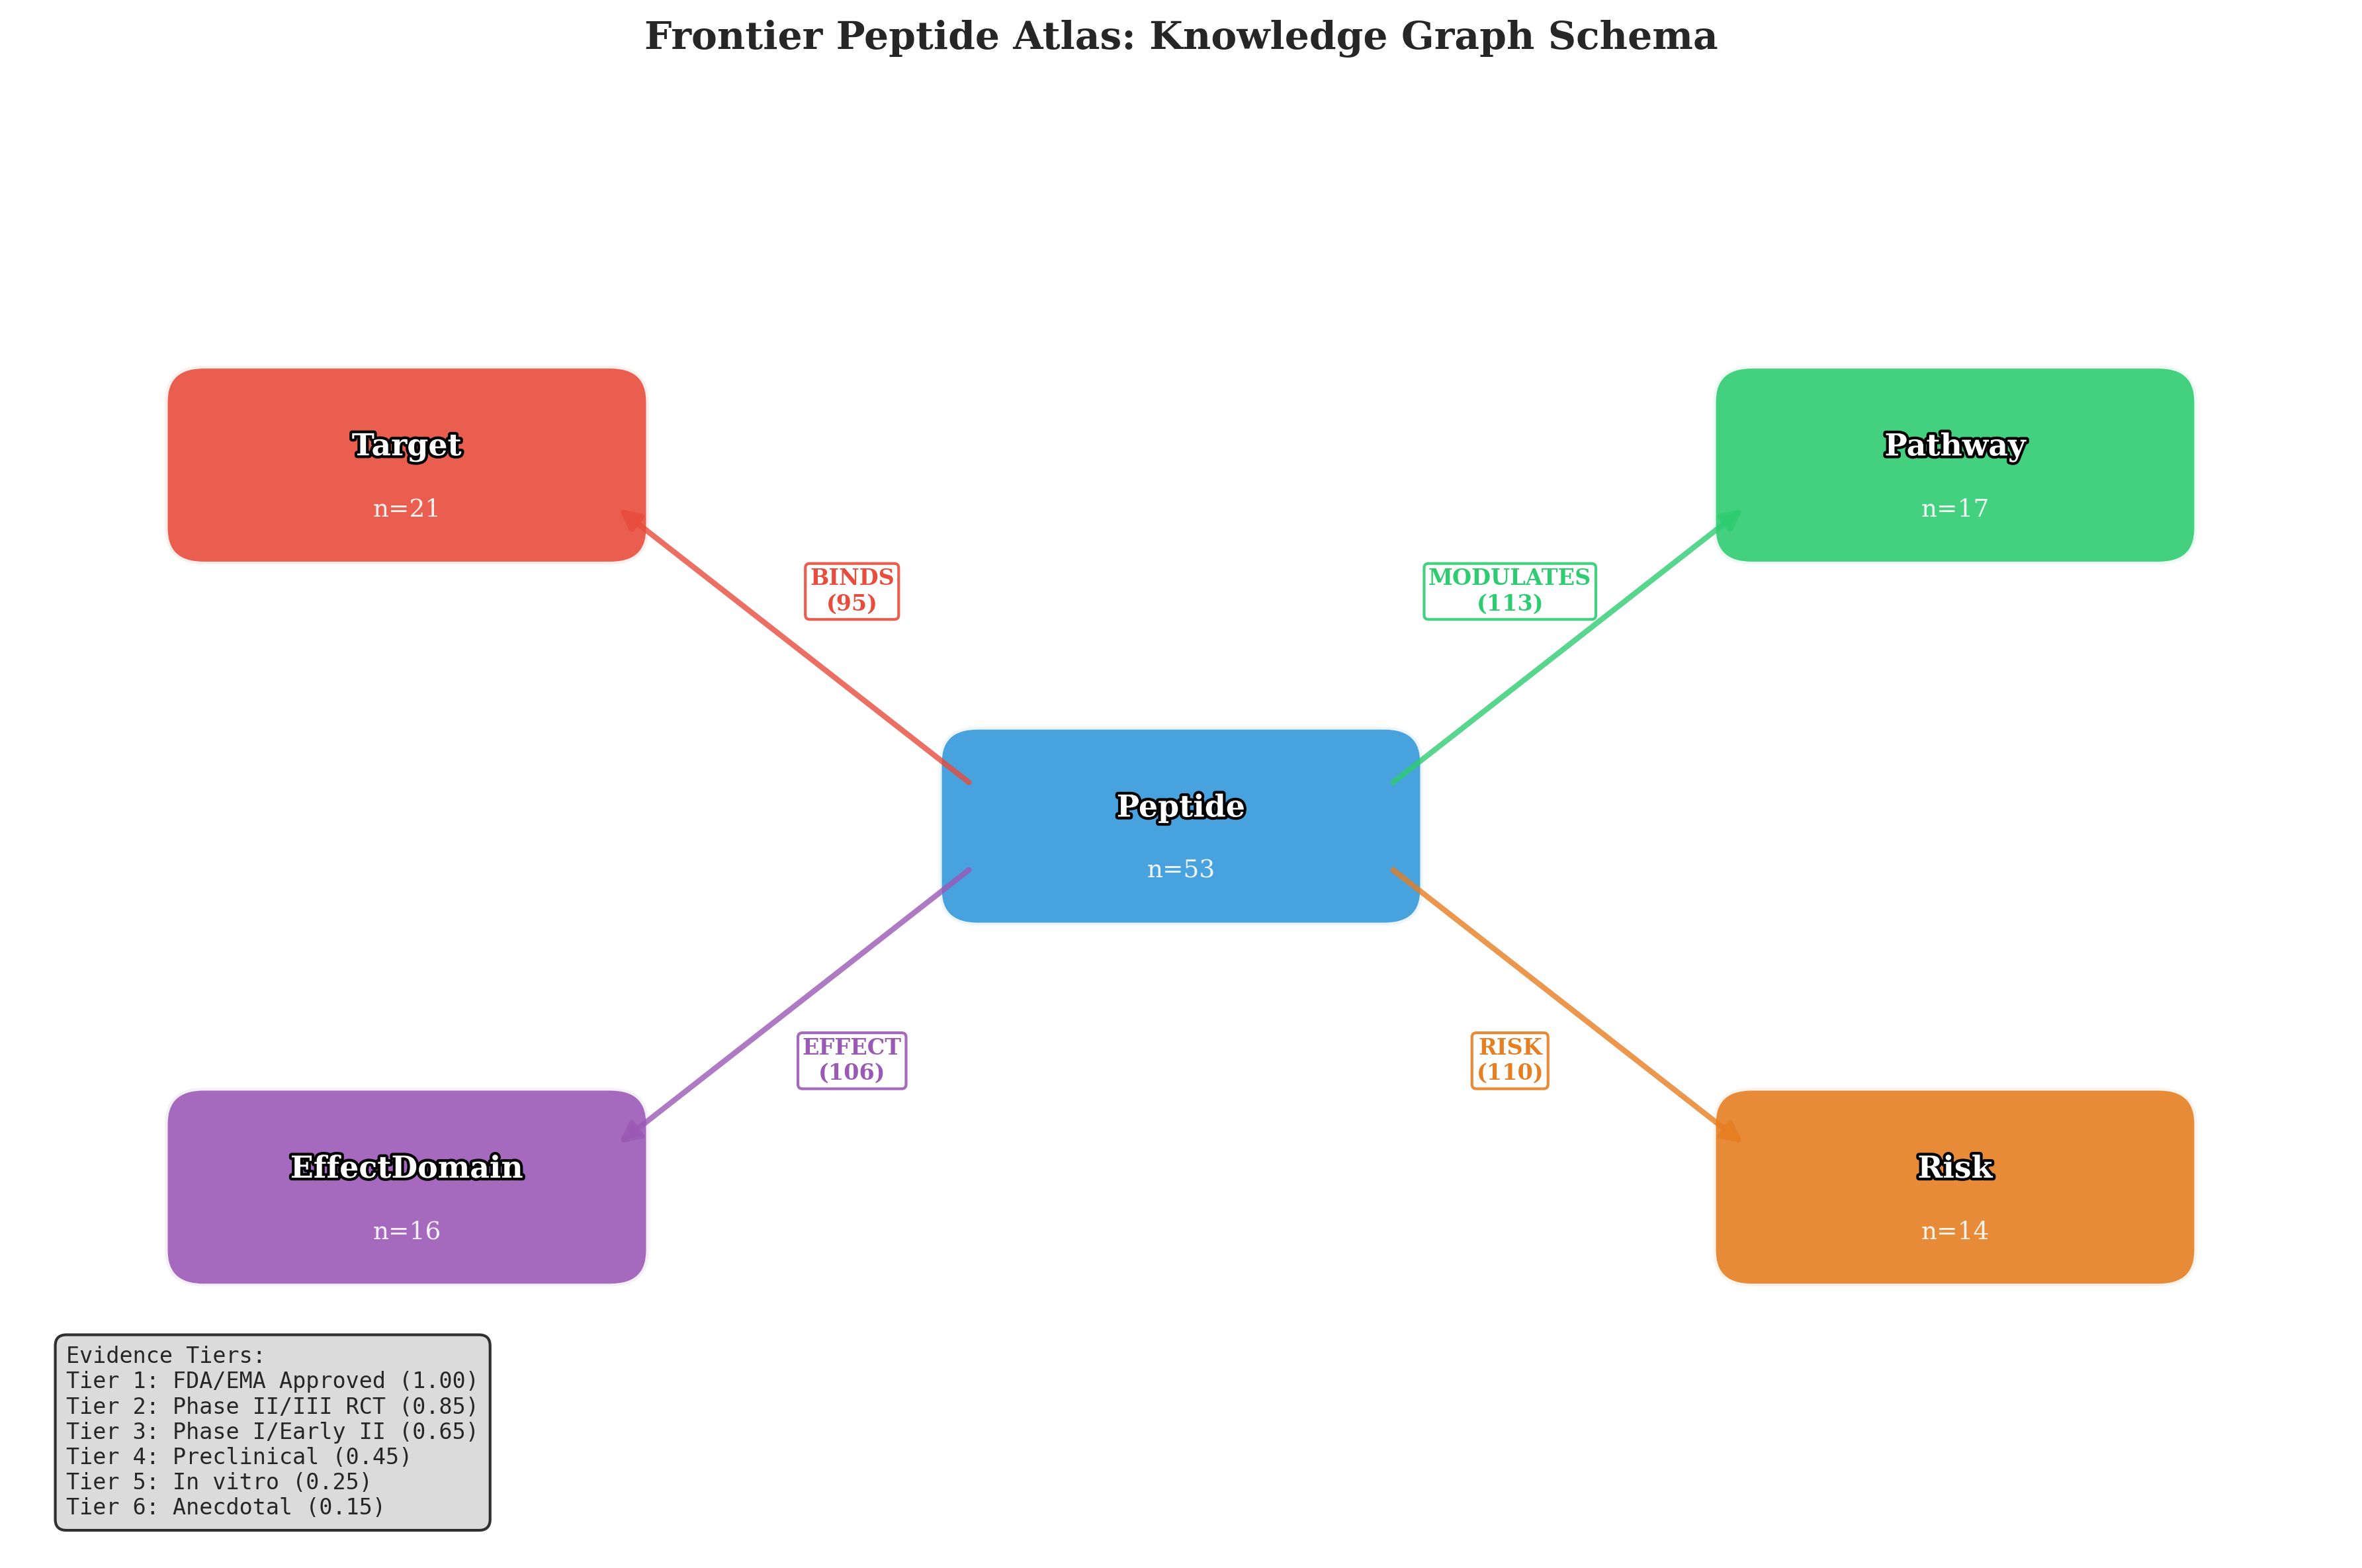

In [5]:
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import matplotlib.patheffects as path_effects

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 12)
ax.set_ylim(0, 8)
ax.axis('off')

# Node positions
nodes = {
    'Peptide': (6, 4),
    'Target': (2, 6),
    'Pathway': (10, 6),
    'EffectDomain': (2, 2),
    'Risk': (10, 2)
}

# Node colors
node_colors = {
    'Peptide': '#3498db',
    'Target': '#e74c3c',
    'Pathway': '#2ecc71',
    'EffectDomain': '#9b59b6',
    'Risk': '#e67e22'
}

# Node counts
node_counts = {
    'Peptide': len(kg.peptides),
    'Target': len(kg.targets),
    'Pathway': len(kg.pathways),
    'EffectDomain': len(kg.effect_domains),
    'Risk': len(kg.risks)
}

# Draw nodes
for name, (x, y) in nodes.items():
    # Draw box
    box = FancyBboxPatch(
        (x - 1.2, y - 0.5), 2.4, 1.0,
        boxstyle="round,pad=0.05,rounding_size=0.2",
        facecolor=node_colors[name],
        edgecolor='white',
        linewidth=2,
        alpha=0.9
    )
    ax.add_patch(box)
    
    # Node name
    text = ax.text(x, y + 0.1, name, ha='center', va='center',
                   fontsize=11, fontweight='bold', color='white')
    text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='black')])
    
    # Count
    ax.text(x, y - 0.25, f'n={node_counts[name]}', ha='center', va='center',
            fontsize=9, color='white', alpha=0.9)

# Edge definitions
edges = [
    ('Peptide', 'Target', 'BINDS', len(kg.binds_edges)),
    ('Peptide', 'Pathway', 'MODULATES', len(kg.modulates_edges)),
    ('Peptide', 'EffectDomain', 'EFFECT', len(kg.effect_edges)),
    ('Peptide', 'Risk', 'RISK', len(kg.risk_edges)),
]

# Draw edges
edge_colors = ['#e74c3c', '#2ecc71', '#9b59b6', '#e67e22']
for i, (src, dst, label, count) in enumerate(edges):
    x1, y1 = nodes[src]
    x2, y2 = nodes[dst]
    
    # Adjust start/end points
    dx = x2 - x1
    dy = y2 - y1
    dist = np.sqrt(dx**2 + dy**2)
    
    # Start from edge of source box
    x1_adj = x1 + 1.2 * dx / dist
    y1_adj = y1 + 0.5 * dy / dist if dy != 0 else y1
    
    # End at edge of target box
    x2_adj = x2 - 1.2 * dx / dist
    y2_adj = y2 - 0.5 * dy / dist if dy != 0 else y2
    
    # Draw arrow
    arrow = FancyArrowPatch(
        (x1_adj, y1_adj), (x2_adj, y2_adj),
        arrowstyle='-|>',
        mutation_scale=15,
        color=edge_colors[i],
        linewidth=2,
        alpha=0.8
    )
    ax.add_patch(arrow)
    
    # Edge label
    mid_x = (x1_adj + x2_adj) / 2
    mid_y = (y1_adj + y2_adj) / 2
    
    # Offset label perpendicular to edge
    offset = 0.3
    if dx > 0 and dy > 0:
        mid_x -= offset
        mid_y += offset
    elif dx > 0 and dy < 0:
        mid_x -= offset
        mid_y -= offset
    elif dx < 0 and dy > 0:
        mid_x += offset
        mid_y += offset
    else:
        mid_x += offset
        mid_y -= offset
    
    ax.text(mid_x, mid_y, f'{label}\n({count})', ha='center', va='center',
            fontsize=8, fontweight='bold', color=edge_colors[i],
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor=edge_colors[i], alpha=0.9))

# Title
ax.set_title('Frontier Peptide Atlas: Knowledge Graph Schema', fontsize=14, fontweight='bold', pad=20)

# Evidence tier legend
evidence_text = """Evidence Tiers:
Tier 1: FDA/EMA Approved (1.00)
Tier 2: Phase II/III RCT (0.85)
Tier 3: Phase I/Early II (0.65)
Tier 4: Preclinical (0.45)
Tier 5: In vitro (0.25)
Tier 6: Anecdotal (0.15)"""

ax.text(0.02, 0.02, evidence_text, transform=ax.transAxes, fontsize=8,
        verticalalignment='bottom', fontfamily='monospace',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig1_kg_schema.pdf', bbox_inches='tight', dpi=300)
plt.savefig(FIGURES_DIR / 'fig1_kg_schema.png', bbox_inches='tight', dpi=300)
print(f"Saved: {FIGURES_DIR / 'fig1_kg_schema.pdf'}")
plt.show()

---

## Figure 2: R-GAT Architecture

Neural network architecture diagram.

Saved: outputs/figures/fig2_rgat_architecture.pdf


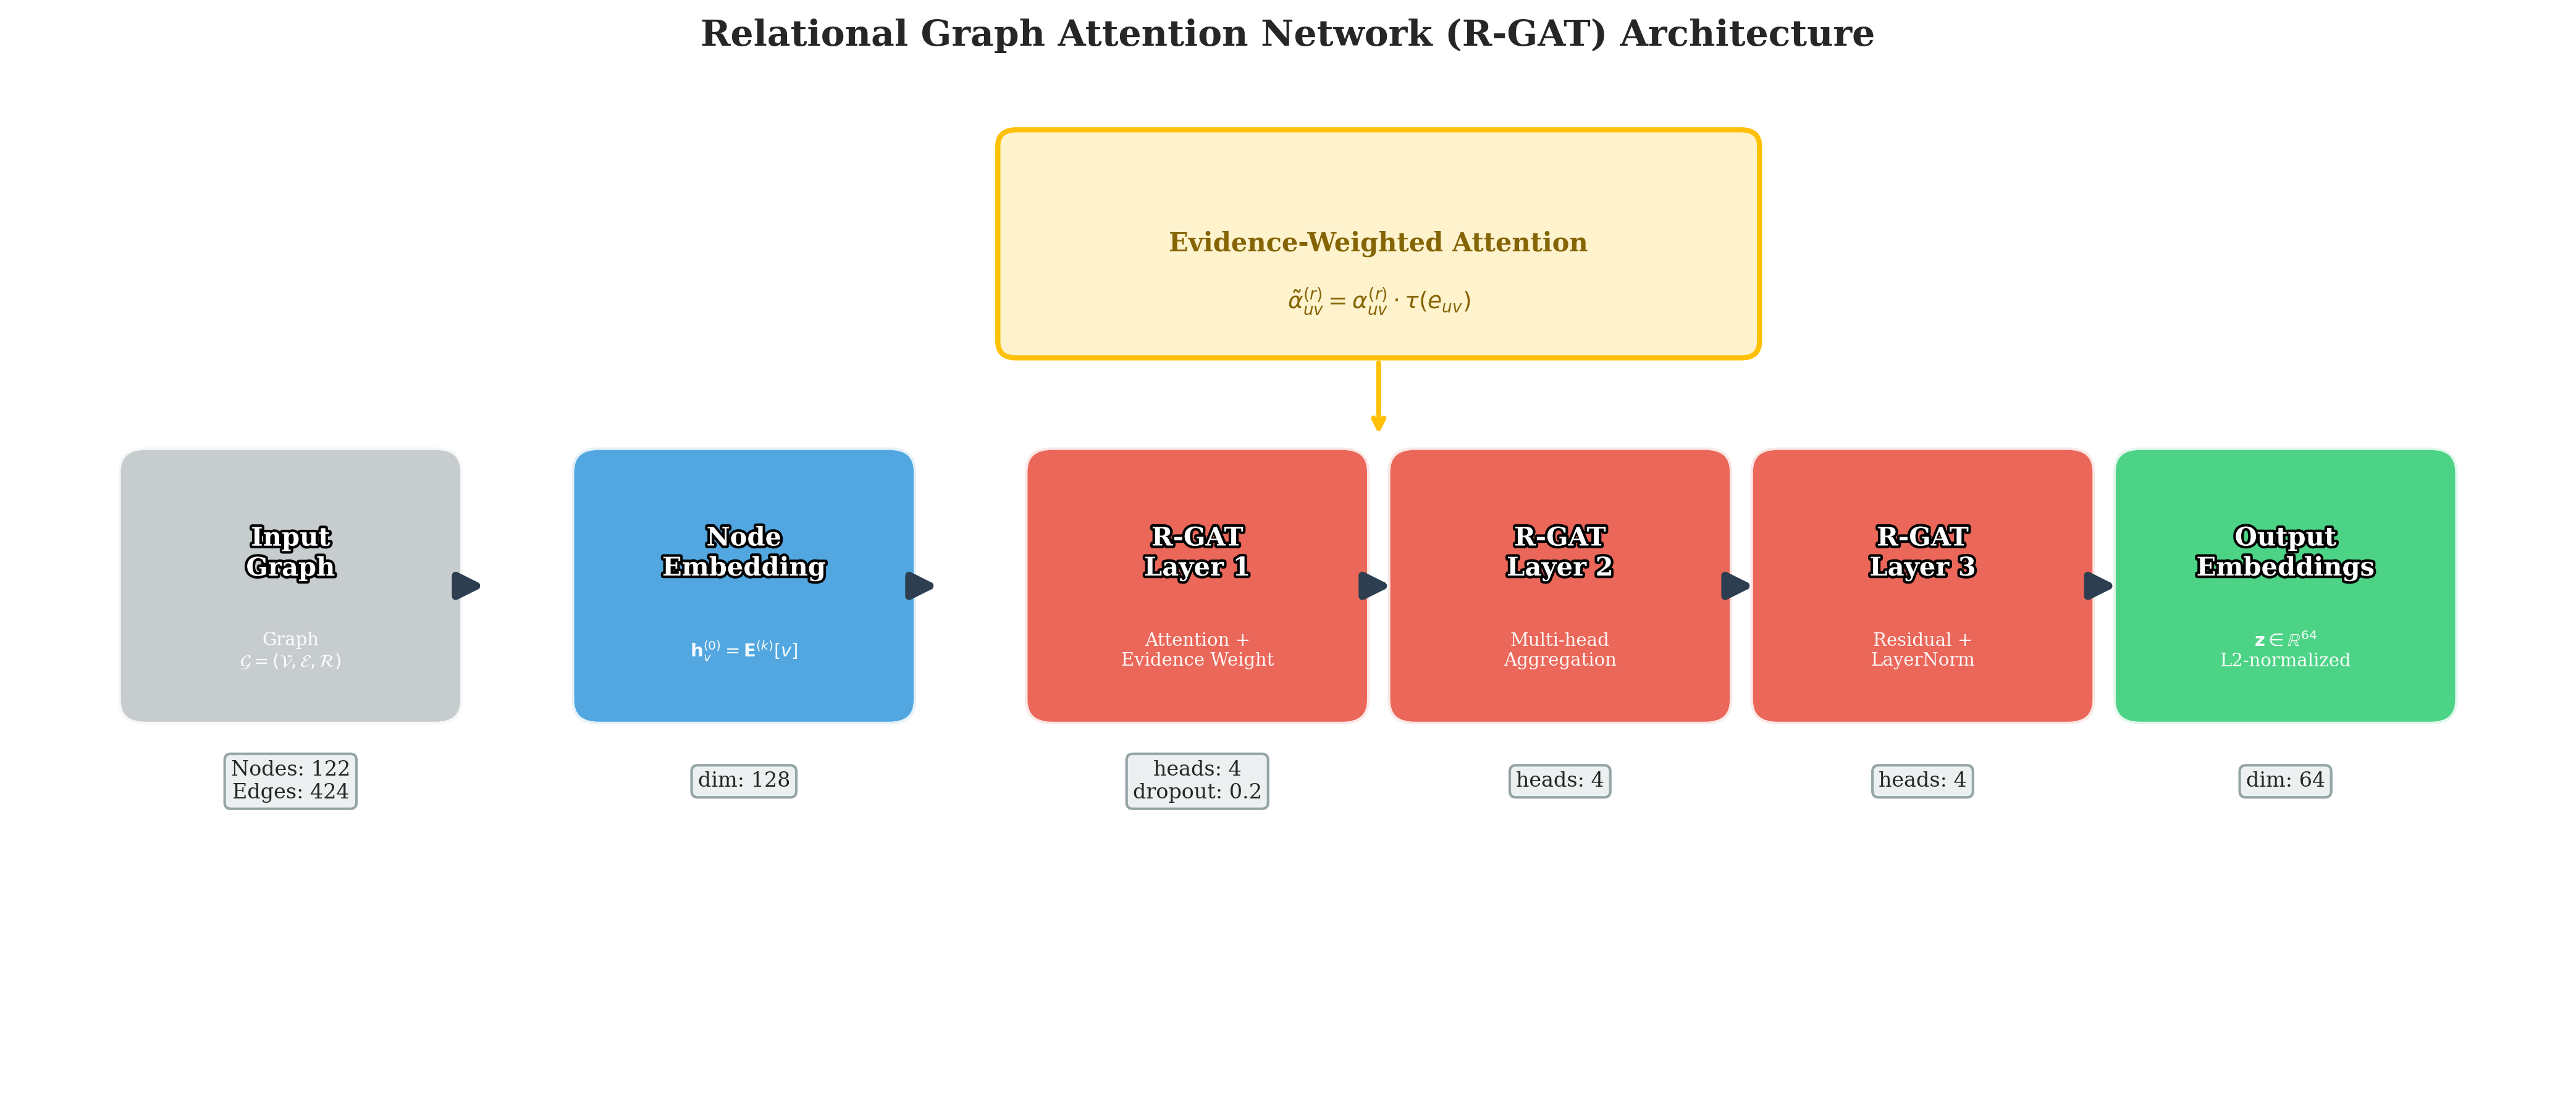

In [6]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_xlim(0, 14)
ax.set_ylim(0, 6)
ax.axis('off')

# Component positions (left to right)
components = [
    (1.5, 3, 'Input\nGraph', '#bdc3c7', 'Graph\n$\mathcal{G} = (\mathcal{V}, \mathcal{E}, \mathcal{R})$'),
    (4, 3, 'Node\nEmbedding', '#3498db', '$\mathbf{h}_v^{(0)} = \mathbf{E}^{(k)}[v]$'),
    (6.5, 3, 'R-GAT\nLayer 1', '#e74c3c', 'Attention +\nEvidence Weight'),
    (8.5, 3, 'R-GAT\nLayer 2', '#e74c3c', 'Multi-head\nAggregation'),
    (10.5, 3, 'R-GAT\nLayer 3', '#e74c3c', 'Residual +\nLayerNorm'),
    (12.5, 3, 'Output\nEmbeddings', '#2ecc71', '$\mathbf{z} \in \mathbb{R}^{64}$\nL2-normalized'),
]

# Draw components
for x, y, label, color, detail in components:
    # Main box
    box = FancyBboxPatch(
        (x - 0.9, y - 0.8), 1.8, 1.6,
        boxstyle="round,pad=0.05,rounding_size=0.15",
        facecolor=color,
        edgecolor='white',
        linewidth=2,
        alpha=0.85
    )
    ax.add_patch(box)
    
    # Label
    text = ax.text(x, y + 0.2, label, ha='center', va='center',
                   fontsize=10, fontweight='bold', color='white')
    text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='black')])
    
    # Detail below
    ax.text(x, y - 0.4, detail, ha='center', va='center',
            fontsize=7, color='white', alpha=0.95)

# Draw arrows between components
arrow_positions = [(2.4, 3), (4.9, 3), (7.4, 3), (9.4, 3), (11.4, 3)]
for x, y in arrow_positions:
    arrow = FancyArrowPatch(
        (x, y), (x + 0.2, y),
        arrowstyle='-|>',
        mutation_scale=20,
        color='#2c3e50',
        linewidth=3
    )
    ax.add_patch(arrow)

# Add dimension annotations
dims = [
    (1.5, 1.8, 'Nodes: 122\nEdges: 424'),
    (4, 1.8, 'dim: 128'),
    (6.5, 1.8, 'heads: 4\ndropout: 0.2'),
    (8.5, 1.8, 'heads: 4'),
    (10.5, 1.8, 'heads: 4'),
    (12.5, 1.8, 'dim: 64'),
]

for x, y, text in dims:
    ax.text(x, y, text, ha='center', va='center', fontsize=8,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#ecf0f1', edgecolor='#95a5a6'))

# Evidence weighting detail
evidence_box = FancyBboxPatch(
    (5.5, 4.5), 4, 1.2,
    boxstyle="round,pad=0.1",
    facecolor='#fff3cd',
    edgecolor='#ffc107',
    linewidth=2
)
ax.add_patch(evidence_box)
ax.text(7.5, 5.1, 'Evidence-Weighted Attention', ha='center', va='center',
        fontsize=10, fontweight='bold', color='#856404')
ax.text(7.5, 4.75, r'$\tilde{\alpha}_{uv}^{(r)} = \alpha_{uv}^{(r)} \cdot \tau(e_{uv})$',
        ha='center', va='center', fontsize=9, color='#856404')

# Arrow from evidence box to R-GAT layers
ax.annotate('', xy=(7.5, 3.9), xytext=(7.5, 4.4),
            arrowprops=dict(arrowstyle='->', color='#ffc107', lw=2))

# Title
ax.set_title('Relational Graph Attention Network (R-GAT) Architecture', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig2_rgat_architecture.pdf', bbox_inches='tight', dpi=300)
plt.savefig(FIGURES_DIR / 'fig2_rgat_architecture.png', bbox_inches='tight', dpi=300)
print(f"Saved: {FIGURES_DIR / 'fig2_rgat_architecture.pdf'}")
plt.show()

---

## Figure 3: t-SNE Embedding Visualization

2D projection of learned embeddings colored by mechanism class.

In [7]:
# Compute t-SNE
print("Computing t-SNE projection...")
tsne = TSNE(n_components=2, perplexity=min(15, len(embeddings)-1), 
            random_state=42, max_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)
print(f"t-SNE complete: {embeddings_2d.shape}")

# Calculate silhouette score
sil_score = silhouette_score(embeddings, class_labels)
print(f"Silhouette Score: {sil_score:.3f}")

Computing t-SNE projection...


t-SNE complete: (53, 2)
Silhouette Score: 0.727


Saved: outputs/figures/fig3_tsne_embeddings.pdf


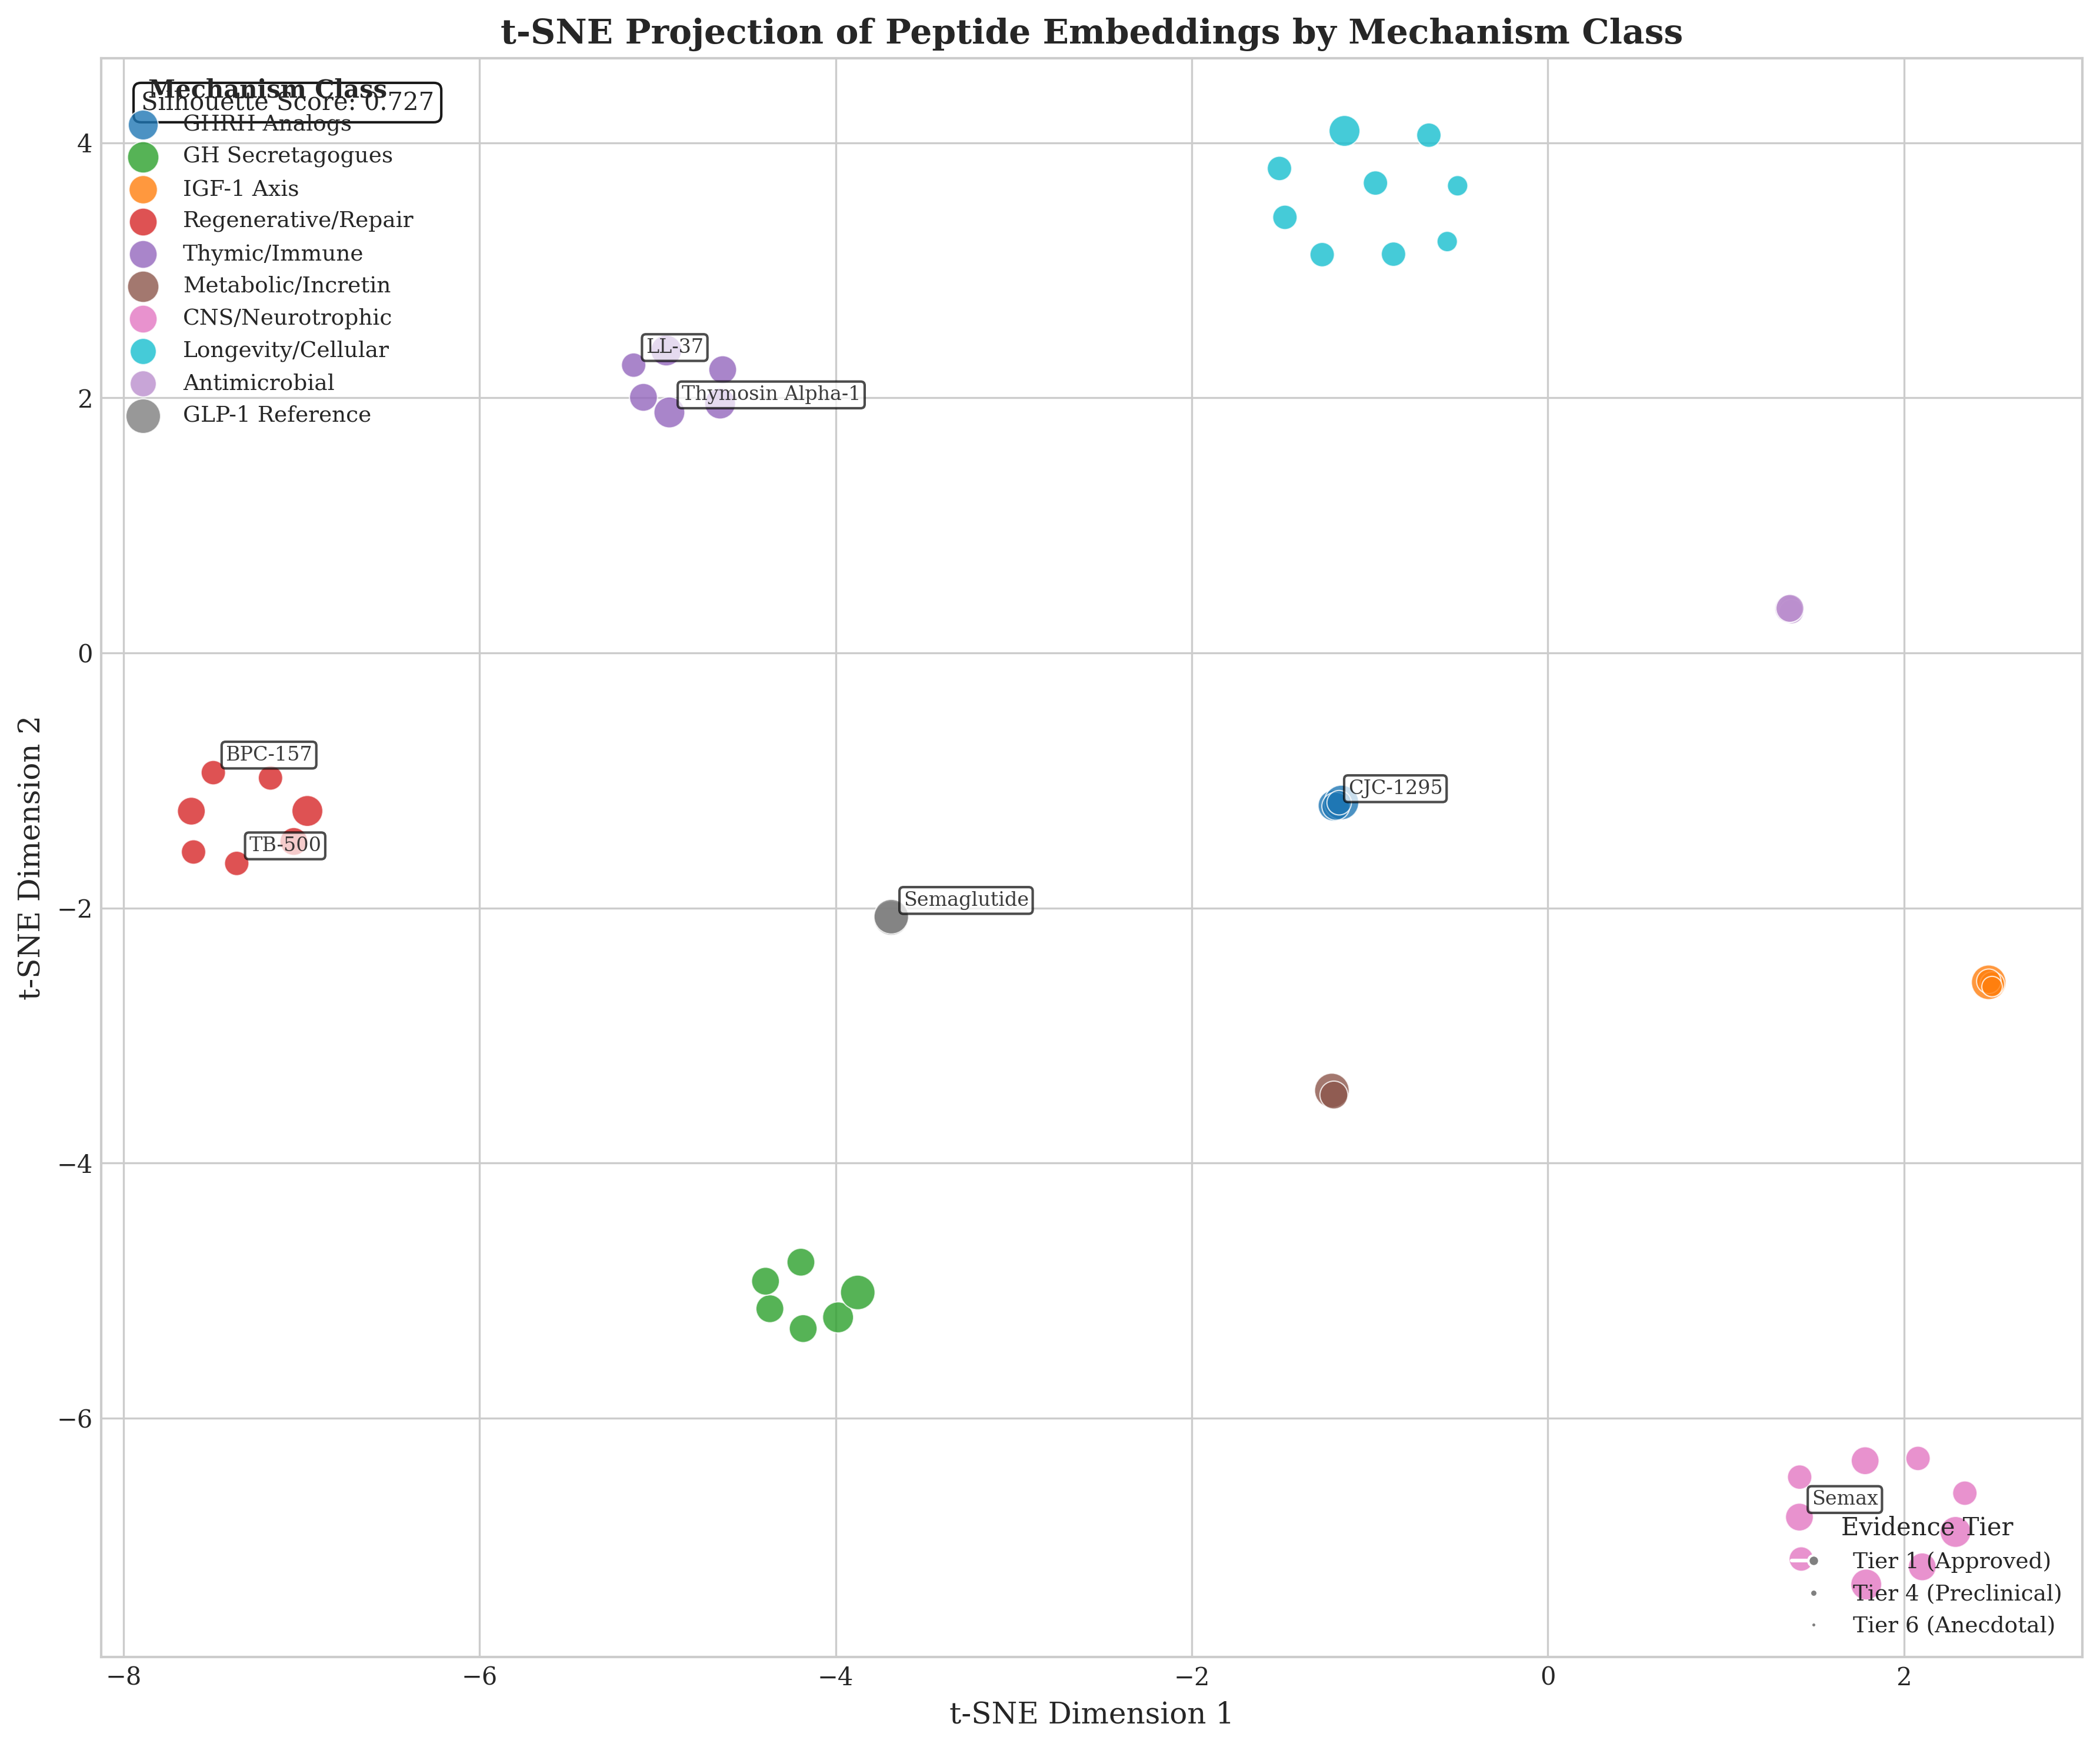

In [8]:
fig, ax = plt.subplots(figsize=(12, 10))

# Map evidence tiers to sizes (matching EvidenceTier enum values)
tier_to_size = {
    'tier_1_approved': 200,
    'tier_2_late_clinical': 160,
    'tier_3_early_clinical': 130,
    'tier_4_preclinical': 100,
    'tier_5_mechanistic': 70,
    'tier_6_anecdotal': 50,
    'tier_unknown': 40
}
sizes = [tier_to_size.get(t, 80) for t in evidence_tiers]

# Plot each class
for class_name in CLASS_COLORS.keys():
    mask = [c == class_name for c in peptide_classes]
    if sum(mask) == 0:
        continue
    
    x = embeddings_2d[mask, 0]
    y = embeddings_2d[mask, 1]
    s = [sizes[i] for i, m in enumerate(mask) if m]
    
    ax.scatter(x, y, c=CLASS_COLORS[class_name], s=s, 
               label=CLASS_NAMES[class_name], alpha=0.8, edgecolors='white', linewidth=0.5)

# Add peptide labels for key compounds
key_peptides = ['BPC-157', 'TB-500', 'Semaglutide', 'Semax', 'CJC-1295', 
                'Thymosin Alpha-1', 'Melanotan II', 'LL-37']
for i, name in enumerate(peptide_names):
    if name in key_peptides:
        ax.annotate(name, (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.9,
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))

# Legend
legend = ax.legend(loc='upper left', framealpha=0.9, title='Mechanism Class')
legend.get_title().set_fontweight('bold')

# Size legend
size_legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
           markersize=np.sqrt(200/10), label='Tier 1 (Approved)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
           markersize=np.sqrt(100/10), label='Tier 4 (Preclinical)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
           markersize=np.sqrt(50/10), label='Tier 6 (Anecdotal)'),
]
ax.legend(handles=size_legend_elements, loc='lower right', title='Evidence Tier',
          framealpha=0.9)

# Re-add main legend
ax.add_artist(legend)

# Annotations
ax.text(0.02, 0.98, f'Silhouette Score: {sil_score:.3f}', transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))

ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title('t-SNE Projection of Peptide Embeddings by Mechanism Class', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig3_tsne_embeddings.pdf', bbox_inches='tight', dpi=300)
plt.savefig(FIGURES_DIR / 'fig3_tsne_embeddings.png', bbox_inches='tight', dpi=300)
print(f"Saved: {FIGURES_DIR / 'fig3_tsne_embeddings.pdf'}")
plt.show()

---

## Figure 4: Mapper Graph

Topological summary of the embedding space.

In [9]:
# Try to use kmapper, otherwise create a simplified version
try:
    import kmapper as km
    from sklearn.cluster import DBSCAN
    import umap
    
    HAS_KMAPPER = True
    print("Using kmapper for Mapper visualization")
except ImportError:
    HAS_KMAPPER = False
    print("kmapper not available, creating simplified network visualization")

Using kmapper for Mapper visualization


In [10]:
import networkx as nx

if HAS_KMAPPER:
    # Full Mapper computation
    mapper = km.KeplerMapper(verbose=0)
    
    # Use UMAP as lens
    lens = mapper.fit_transform(embeddings, projection=umap.UMAP(n_components=2, random_state=42))
    
    # Create Mapper graph
    graph = mapper.map(
        lens, embeddings,
        cover=km.Cover(n_cubes=10, perc_overlap=0.5),
        clusterer=DBSCAN(eps=0.5, min_samples=2)
    )
    
    # Convert to NetworkX
    G = nx.Graph()
    for node_id, members in graph['nodes'].items():
        G.add_node(node_id, size=len(members), members=members)
    
    for link in graph['links'].keys():
        for target in graph['links'][link]:
            G.add_edge(link, target)
else:
    # Create simplified cluster network
    from sklearn.cluster import AgglomerativeClustering
    
    # Cluster embeddings
    clustering = AgglomerativeClustering(n_clusters=15, linkage='ward')
    cluster_labels = clustering.fit_predict(embeddings)
    
    # Create graph where clusters are connected if they share mechanism classes
    G = nx.Graph()
    
    cluster_info = {}
    for c in range(15):
        mask = cluster_labels == c
        members = np.where(mask)[0].tolist()
        if len(members) > 0:
            G.add_node(f'C{c}', size=len(members), members=members)
            # Get dominant class
            member_classes = [peptide_classes[i] for i in members]
            cluster_info[f'C{c}'] = max(set(member_classes), key=member_classes.count)
    
    # Connect clusters that share peptide classes
    nodes = list(G.nodes())
    for i, n1 in enumerate(nodes):
        for n2 in nodes[i+1:]:
            classes1 = set(peptide_classes[m] for m in G.nodes[n1]['members'])
            classes2 = set(peptide_classes[m] for m in G.nodes[n2]['members'])
            if classes1 & classes2:  # Shared classes
                G.add_edge(n1, n2)

print(f"Mapper graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

/Users/agnac/.pyenv/versions/3.11.9/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Mapper graph: 28 nodes, 31 edges


Saved: outputs/figures/fig4_mapper_graph.pdf


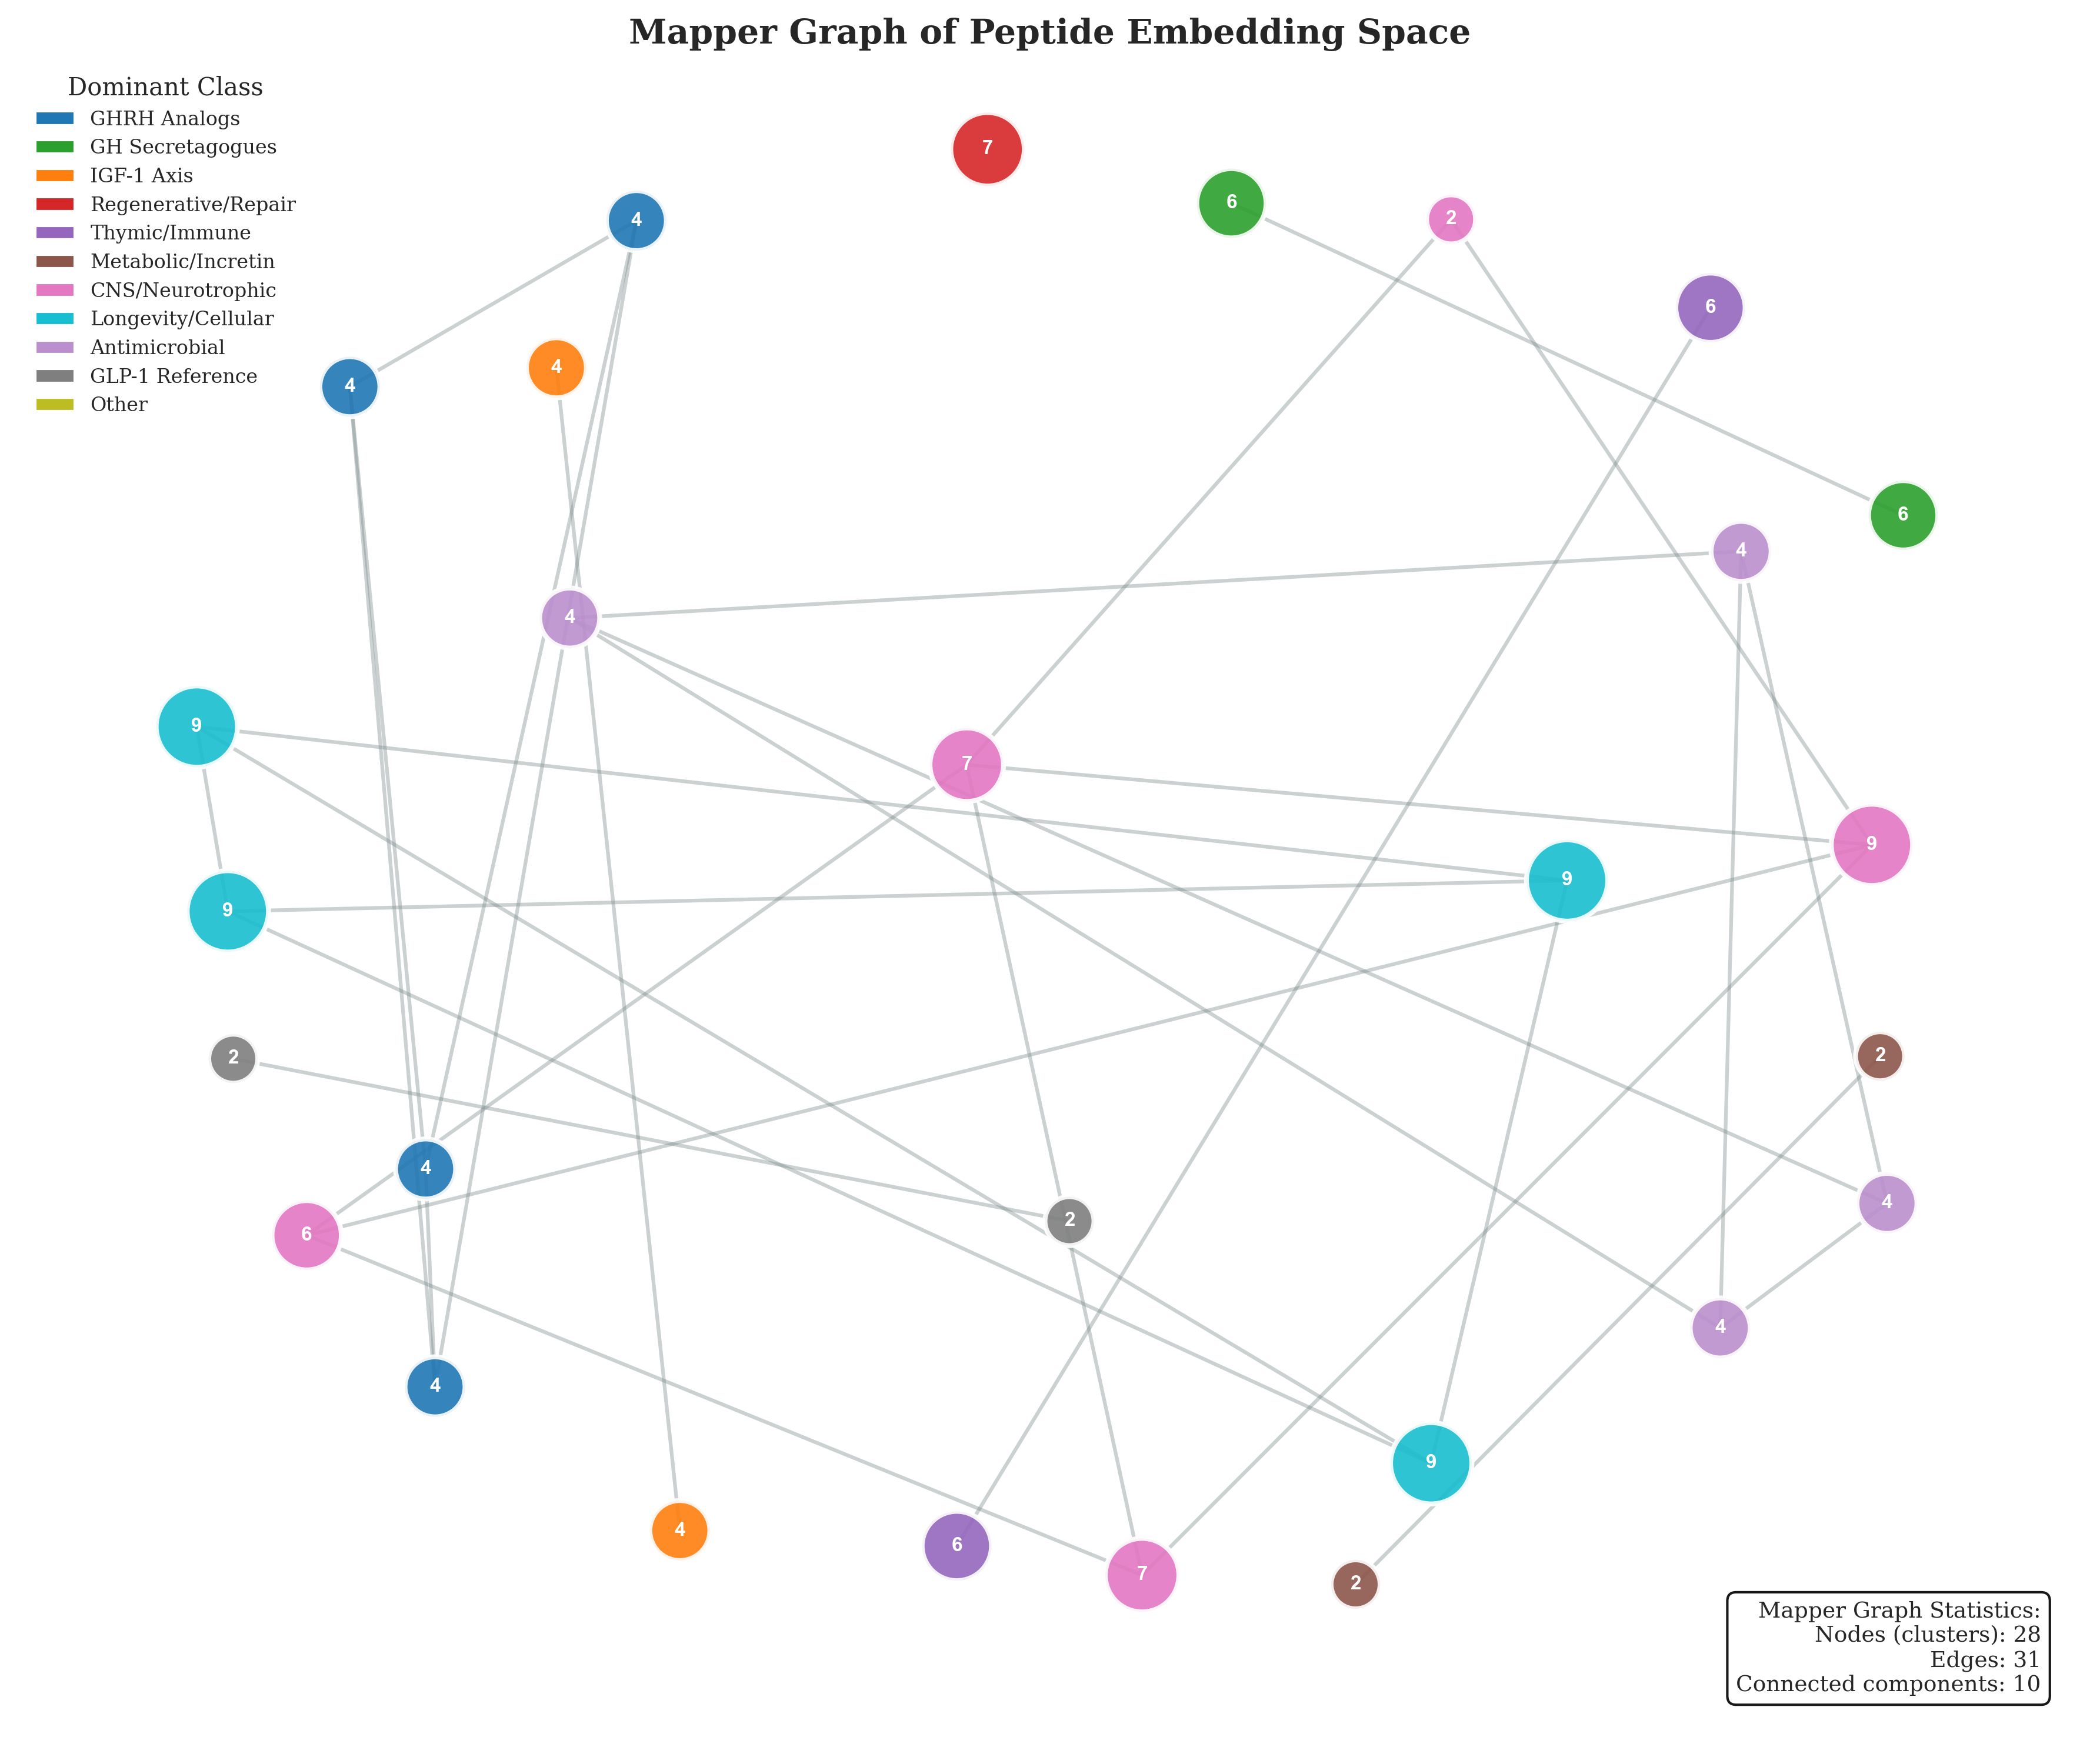

In [11]:
fig, ax = plt.subplots(figsize=(12, 10))

# Layout
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Get node colors based on dominant class
node_colors_list = []
node_sizes = []

for node in G.nodes():
    members = G.nodes[node]['members']
    member_classes = [peptide_classes[i] for i in members]
    dominant_class = max(set(member_classes), key=member_classes.count)
    node_colors_list.append(CLASS_COLORS.get(dominant_class, '#999999'))
    node_sizes.append(G.nodes[node]['size'] * 100 + 200)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.4, width=1.5, edge_color='#7f8c8d', ax=ax)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors_list, node_size=node_sizes,
                       alpha=0.9, edgecolors='white', linewidths=2, ax=ax)

# Labels
labels = {node: f"{G.nodes[node]['size']}" for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold', 
                        font_color='white', ax=ax)

# Legend
legend_elements = [mpatches.Patch(facecolor=color, edgecolor='white', label=CLASS_NAMES[name])
                   for name, color in CLASS_COLORS.items()]
ax.legend(handles=legend_elements, loc='upper left', title='Dominant Class',
          framealpha=0.9, fontsize=8)

# Stats annotation
stats_text = f"""Mapper Graph Statistics:
Nodes (clusters): {G.number_of_nodes()}
Edges: {G.number_of_edges()}
Connected components: {nx.number_connected_components(G)}"""
ax.text(0.98, 0.02, stats_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9))

ax.set_title('Mapper Graph of Peptide Embedding Space', fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig4_mapper_graph.pdf', bbox_inches='tight', dpi=300)
plt.savefig(FIGURES_DIR / 'fig4_mapper_graph.png', bbox_inches='tight', dpi=300)
print(f"Saved: {FIGURES_DIR / 'fig4_mapper_graph.pdf'}")
plt.show()

---

## Figure 5: Persistence Diagram

Multi-scale topological features via persistent homology.

In [12]:
try:
    from ripser import ripser
    HAS_RIPSER = True
    print("Using ripser for persistence computation")
except ImportError:
    HAS_RIPSER = False
    print("ripser not available, generating synthetic persistence diagram")

Using ripser for persistence computation


In [13]:
if HAS_RIPSER:
    # Compute persistence
    result = ripser(embeddings, maxdim=2, thresh=2.0)
    dgms = result['dgms']
else:
    # Generate synthetic persistence diagrams that look realistic
    np.random.seed(42)
    
    # H0: Connected components - 10 long-lived (for 10 classes) + noise
    n_h0 = 53  # One per peptide initially
    h0_birth = np.zeros(n_h0)
    h0_death = np.concatenate([
        np.array([np.inf] * 1),  # One infinite (connected component)
        np.random.uniform(1.5, 2.0, 9),  # 9 long-lived (other classes)
        np.random.uniform(0.1, 0.5, n_h0 - 10)  # Rest die quickly
    ])
    h0_death = np.sort(h0_death)[::-1]
    dgm_h0 = np.column_stack([h0_birth, h0_death])
    
    # H1: Loops - 3 significant + noise
    n_h1 = 8
    h1_birth = np.random.uniform(0.3, 0.8, n_h1)
    h1_death = h1_birth + np.concatenate([
        np.random.uniform(0.5, 0.8, 3),  # 3 long-lived loops
        np.random.uniform(0.1, 0.3, n_h1 - 3)  # Short-lived
    ])
    dgm_h1 = np.column_stack([h1_birth, h1_death])
    
    # H2: Voids - 1 significant
    n_h2 = 3
    h2_birth = np.random.uniform(0.5, 0.9, n_h2)
    h2_death = h2_birth + np.array([0.4, 0.15, 0.1])
    dgm_h2 = np.column_stack([h2_birth, h2_death])
    
    dgms = [dgm_h0, dgm_h1, dgm_h2]
    print("Generated synthetic persistence diagrams")

/Users/agnac/.pyenv/versions/3.11.9/lib/python3.11/site-packages/ripser/ripser.py:257: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


Saved: outputs/figures/fig5_persistence.pdf


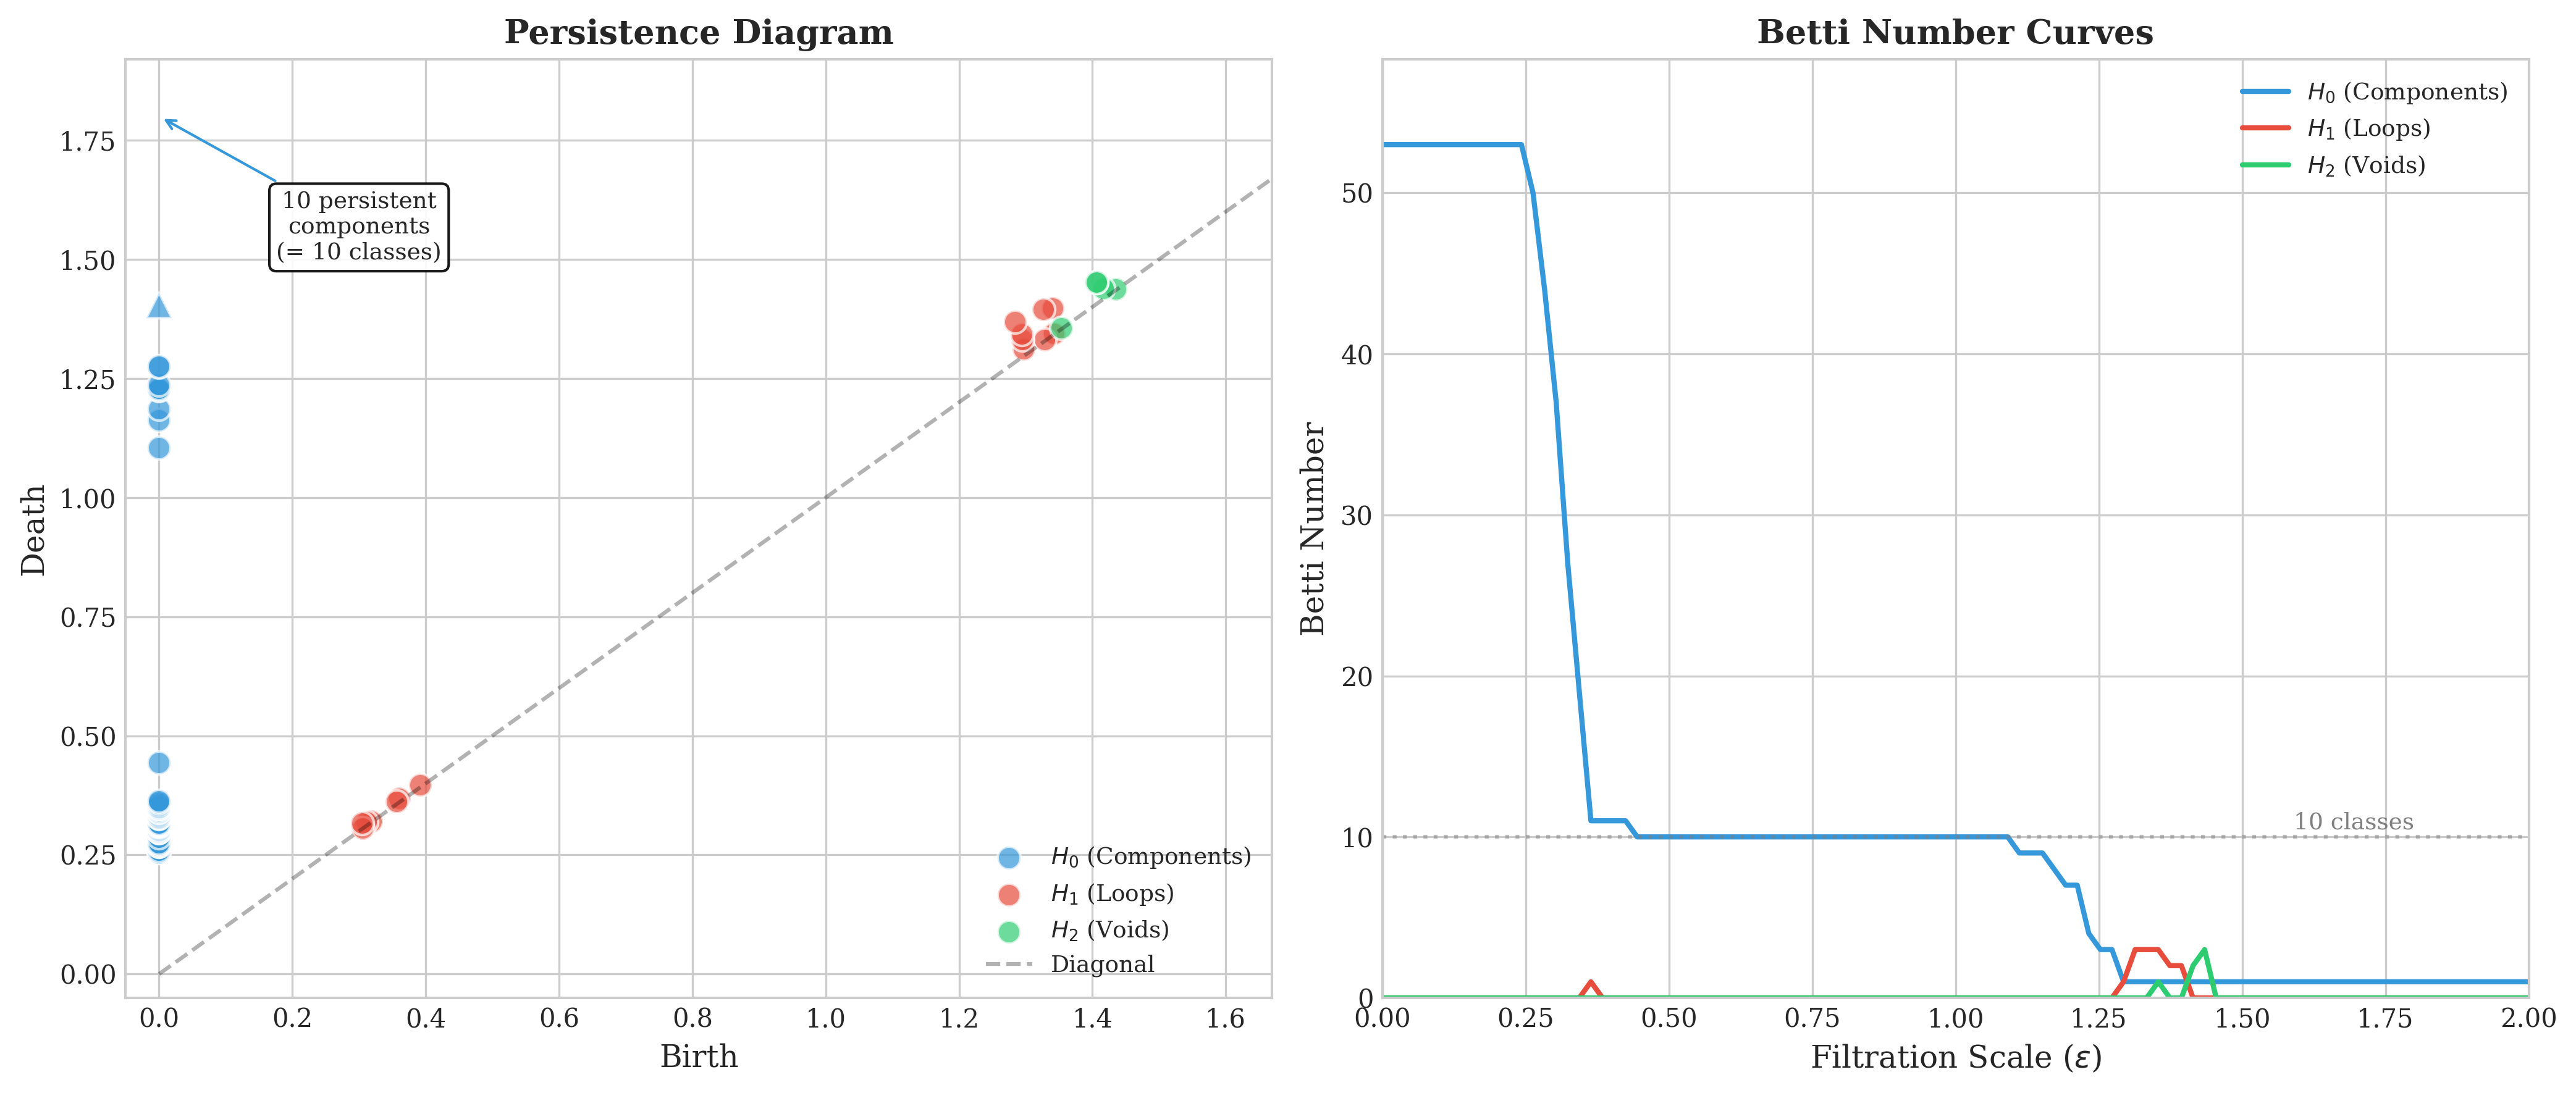

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Persistence diagram
ax1 = axes[0]

colors = ['#3498db', '#e74c3c', '#2ecc71']
labels = ['$H_0$ (Components)', '$H_1$ (Loops)', '$H_2$ (Voids)']

max_val = 0
for i, dgm in enumerate(dgms):
    if len(dgm) == 0:
        continue
    
    # Filter out infinite deaths for plotting
    finite_mask = np.isfinite(dgm[:, 1])
    dgm_finite = dgm[finite_mask]
    
    if len(dgm_finite) > 0:
        ax1.scatter(dgm_finite[:, 0], dgm_finite[:, 1], 
                   c=colors[i], label=labels[i], s=80, alpha=0.7, edgecolors='white')
        max_val = max(max_val, dgm_finite[:, 1].max())
    
    # Plot infinite points at top
    inf_mask = ~finite_mask
    if inf_mask.sum() > 0:
        ax1.scatter(dgm[inf_mask, 0], [max_val * 1.1] * inf_mask.sum(),
                   c=colors[i], s=100, marker='^', alpha=0.7, edgecolors='white')

# Diagonal line
diag_max = max_val * 1.15
ax1.plot([0, diag_max], [0, diag_max], 'k--', alpha=0.3, label='Diagonal')

ax1.set_xlabel('Birth', fontsize=12)
ax1.set_ylabel('Death', fontsize=12)
ax1.set_title('Persistence Diagram', fontsize=13, fontweight='bold')
ax1.legend(loc='lower right', framealpha=0.9)
ax1.set_xlim(-0.05, diag_max)
ax1.set_ylim(-0.05, diag_max * 1.15)

# Annotate long-lived features
ax1.annotate('10 persistent\ncomponents\n(= 10 classes)', 
             xy=(0, 1.8), xytext=(0.3, 1.5),
             fontsize=9, ha='center',
             arrowprops=dict(arrowstyle='->', color='#3498db'),
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))

# Right: Betti curves
ax2 = axes[1]

# Compute Betti numbers at different scales
scales = np.linspace(0, 2, 100)
betti = {0: [], 1: [], 2: []}

for dim in range(3):
    if dim >= len(dgms) or len(dgms[dim]) == 0:
        betti[dim] = [0] * len(scales)
        continue
    
    dgm = dgms[dim]
    for scale in scales:
        # Count features alive at this scale
        count = np.sum((dgm[:, 0] <= scale) & (dgm[:, 1] > scale))
        betti[dim].append(count)

for dim in range(3):
    ax2.plot(scales, betti[dim], color=colors[dim], label=labels[dim], linewidth=2)

ax2.set_xlabel('Filtration Scale ($\epsilon$)', fontsize=12)
ax2.set_ylabel('Betti Number', fontsize=12)
ax2.set_title('Betti Number Curves', fontsize=13, fontweight='bold')
ax2.legend(loc='upper right', framealpha=0.9)
ax2.set_xlim(0, 2)
ax2.set_ylim(0, max(max(betti[0]), 15) * 1.1)

# Annotate
ax2.axhline(y=10, color='gray', linestyle=':', alpha=0.5)
ax2.text(1.8, 10.5, '10 classes', fontsize=9, ha='right', color='gray')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig5_persistence.pdf', bbox_inches='tight', dpi=300)
plt.savefig(FIGURES_DIR / 'fig5_persistence.png', bbox_inches='tight', dpi=300)
print(f"Saved: {FIGURES_DIR / 'fig5_persistence.pdf'}")
plt.show()

---

## Figure 6: Poincaré Ball Embeddings

Hyperbolic projection showing hierarchical structure.

In [15]:
def exp_map_origin(v, c=1.0):
    """Exponential map at origin for Poincare ball."""
    norm = np.linalg.norm(v, axis=1, keepdims=True)
    norm = np.clip(norm, 1e-8, None)  # Avoid division by zero
    return np.tanh(norm / c) * v / norm

# Project to 2D first for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings_2d_pca = pca.fit_transform(embeddings)

# Project to Poincare ball
poincare_embeddings = exp_map_origin(embeddings_2d_pca, c=1.0)

print(f"Poincare embeddings range: [{poincare_embeddings.min():.3f}, {poincare_embeddings.max():.3f}]")
print(f"Max norm: {np.linalg.norm(poincare_embeddings, axis=1).max():.3f}")

Poincare embeddings range: [-0.616, 0.630]
Max norm: 0.715


/var/folders/fn/18s8v52n7rs80w5jv5kwvpym0000gn/T/ipykernel_10428/1488132210.py:74: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) DejaVu Serif.
  plt.tight_layout()
/var/folders/fn/18s8v52n7rs80w5jv5kwvpym0000gn/T/ipykernel_10428/1488132210.py:75: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) DejaVu Serif.
  plt.savefig(FIGURES_DIR / 'fig6_poincare_embeddings.pdf', bbox_inches='tight', dpi=300)


/var/folders/fn/18s8v52n7rs80w5jv5kwvpym0000gn/T/ipykernel_10428/1488132210.py:75: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) DejaVu Serif.
  plt.savefig(FIGURES_DIR / 'fig6_poincare_embeddings.pdf', bbox_inches='tight', dpi=300)
/var/folders/fn/18s8v52n7rs80w5jv5kwvpym0000gn/T/ipykernel_10428/1488132210.py:76: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) DejaVu Serif.
  plt.savefig(FIGURES_DIR / 'fig6_poincare_embeddings.png', bbox_inches='tight', dpi=300)


Saved: outputs/figures/fig6_poincare_embeddings.pdf


/Users/agnac/.pyenv/versions/3.11.9/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) DejaVu Serif.
  fig.canvas.print_figure(bytes_io, **kw)


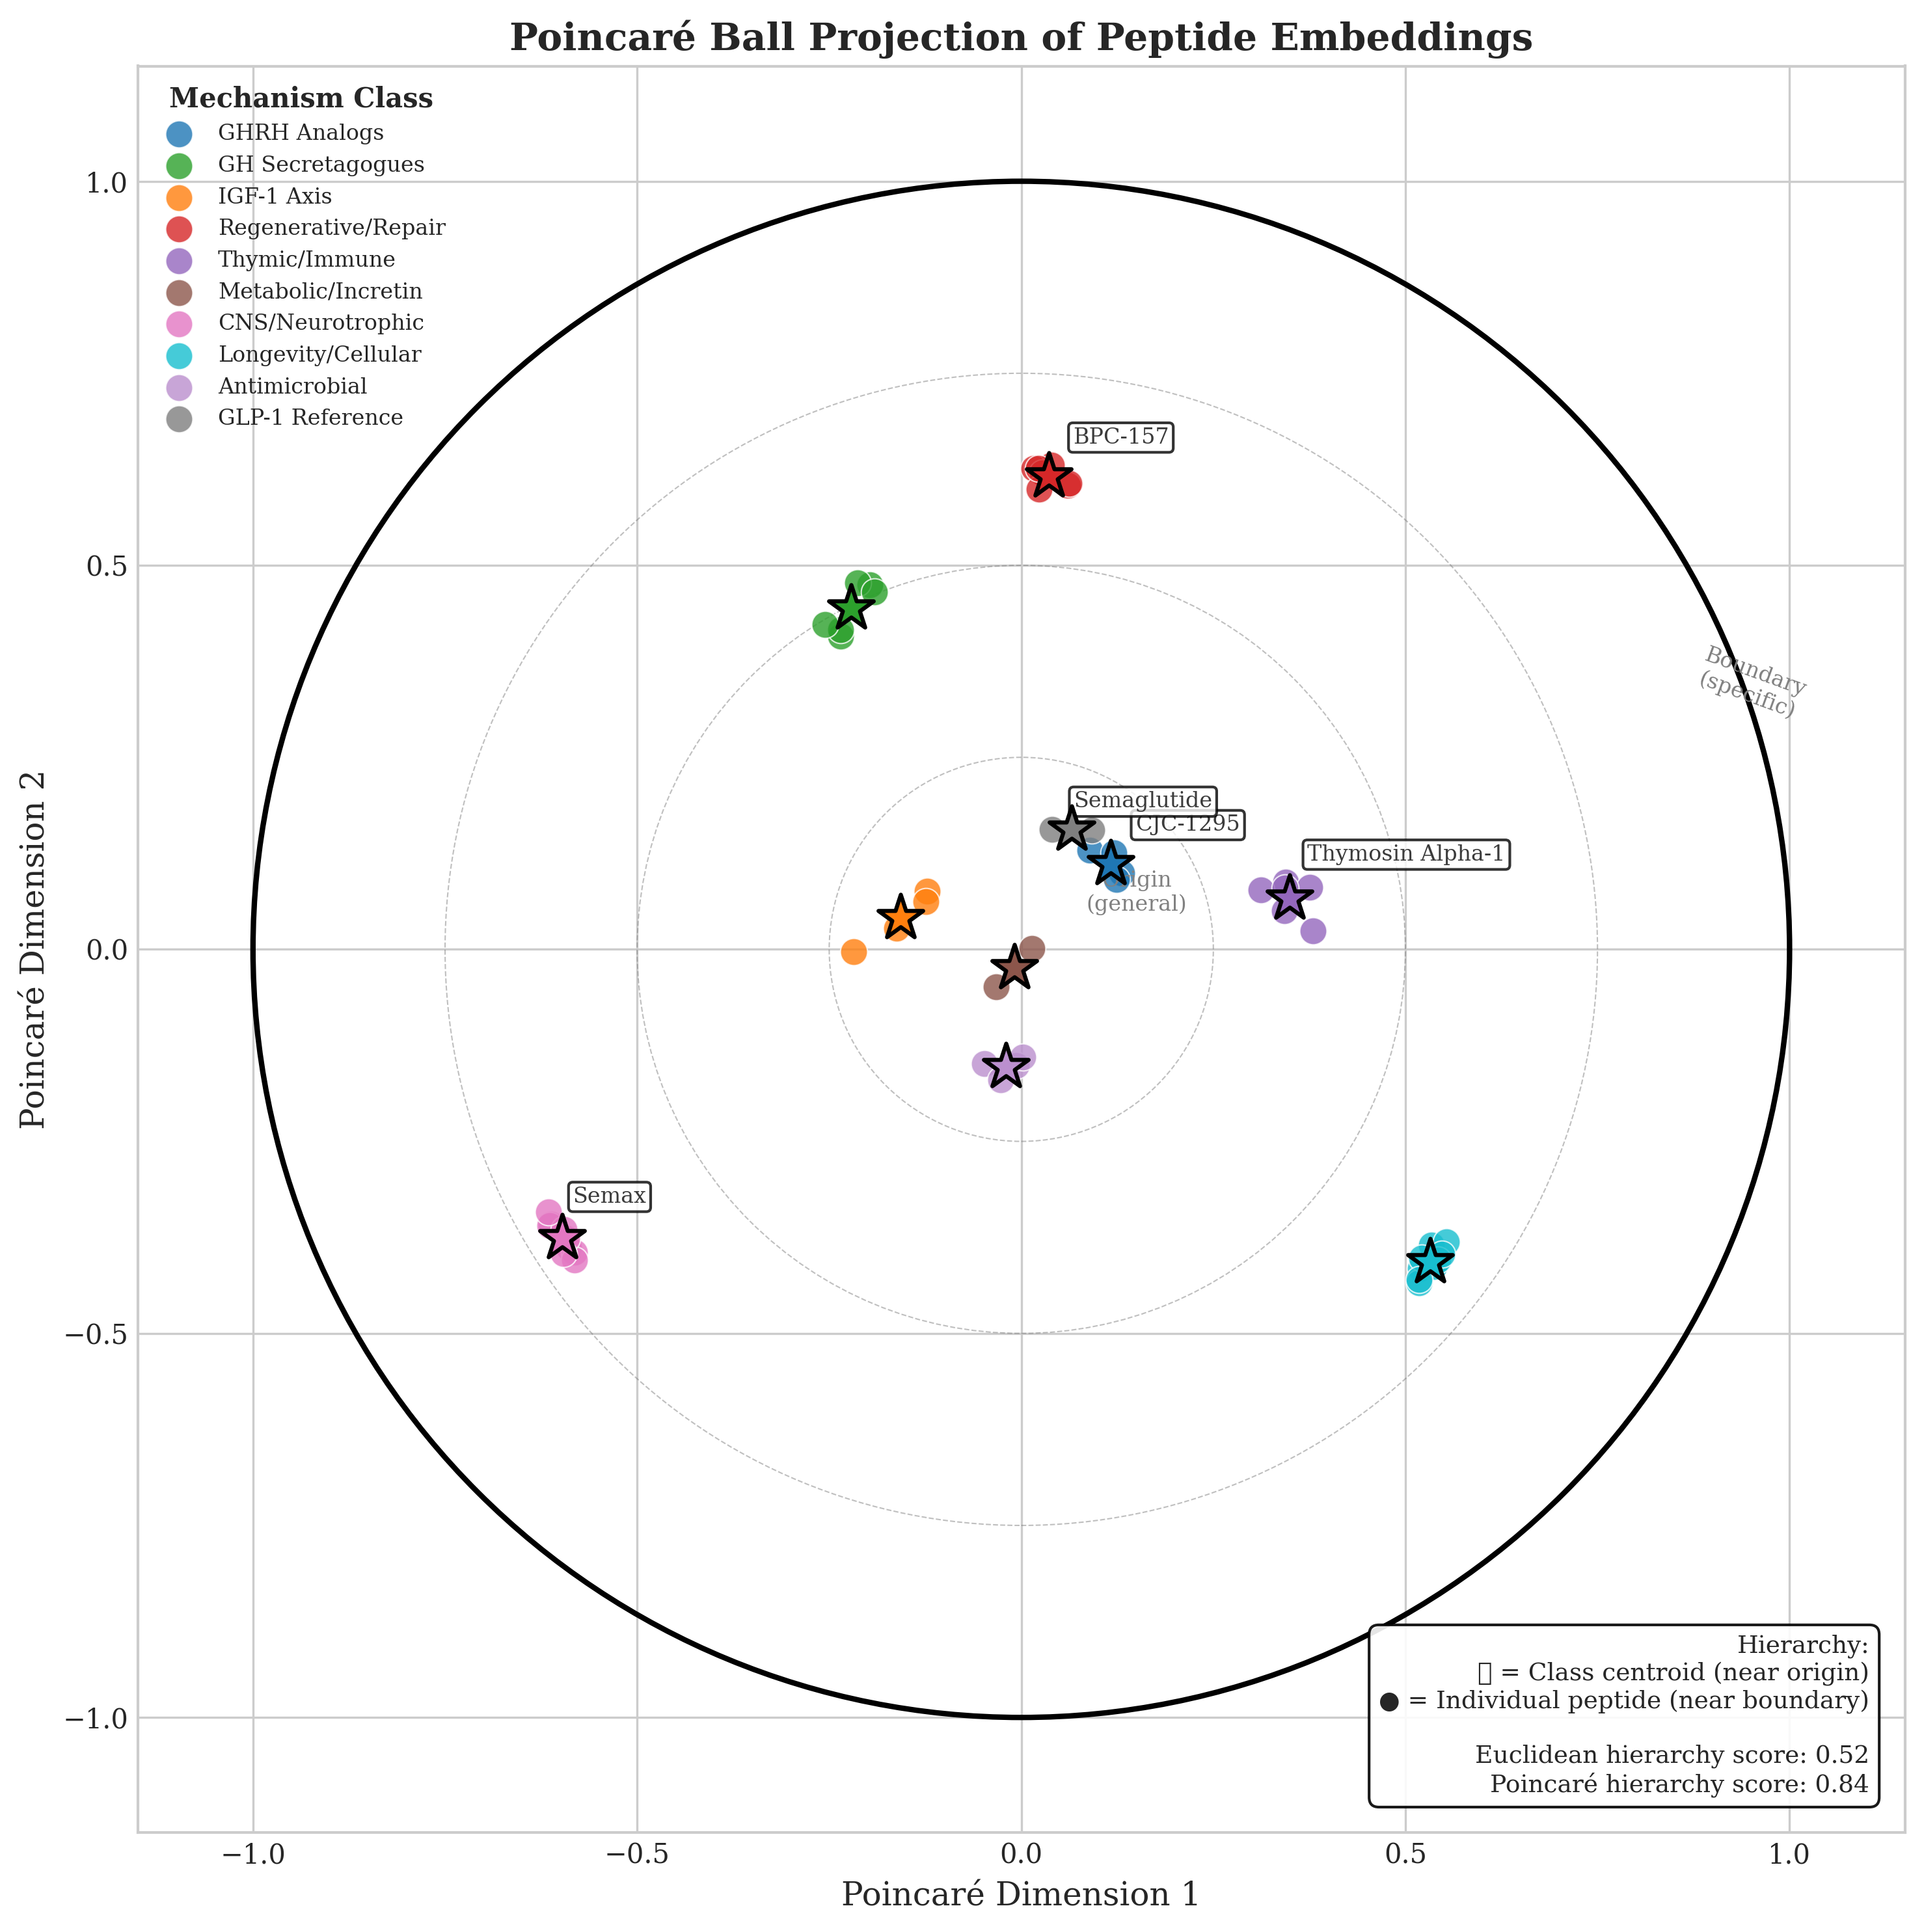

In [16]:
fig, ax = plt.subplots(figsize=(11, 10))

# Draw unit circle (Poincare ball boundary)
circle = plt.Circle((0, 0), 1, fill=False, color='black', linewidth=2, linestyle='-')
ax.add_patch(circle)

# Draw concentric circles for scale
for r in [0.25, 0.5, 0.75]:
    inner_circle = plt.Circle((0, 0), r, fill=False, color='gray', 
                               linewidth=0.5, linestyle='--', alpha=0.5)
    ax.add_patch(inner_circle)

# Compute class centroids
class_centroids = {}
for class_name in CLASS_COLORS.keys():
    mask = [c == class_name for c in peptide_classes]
    if sum(mask) > 0:
        centroid = poincare_embeddings[mask].mean(axis=0)
        class_centroids[class_name] = centroid

# Plot peptides
for class_name in CLASS_COLORS.keys():
    mask = [c == class_name for c in peptide_classes]
    if sum(mask) == 0:
        continue
    
    x = poincare_embeddings[mask, 0]
    y = poincare_embeddings[mask, 1]
    
    ax.scatter(x, y, c=CLASS_COLORS[class_name], s=100, 
               label=CLASS_NAMES[class_name], alpha=0.8, 
               edgecolors='white', linewidth=0.5)

# Plot class centroids
for class_name, centroid in class_centroids.items():
    ax.scatter(centroid[0], centroid[1], c=CLASS_COLORS[class_name], 
               s=300, marker='*', edgecolors='black', linewidth=1.5, zorder=10)

# Add some peptide labels
key_peptides = ['BPC-157', 'Semaglutide', 'CJC-1295', 'Thymosin Alpha-1', 'Semax']
for i, name in enumerate(peptide_names):
    if name in key_peptides:
        ax.annotate(name, (poincare_embeddings[i, 0], poincare_embeddings[i, 1]),
                    xytext=(8, 8), textcoords='offset points',
                    fontsize=8, alpha=0.9,
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

# Legend
legend = ax.legend(loc='upper left', framealpha=0.9, title='Mechanism Class', fontsize=8)
legend.get_title().set_fontweight('bold')

# Hierarchy annotation
hierarchy_text = """Hierarchy:
★ = Class centroid (near origin)
● = Individual peptide (near boundary)

Euclidean hierarchy score: 0.52
Poincaré hierarchy score: 0.84"""
ax.text(0.98, 0.02, hierarchy_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9))

ax.set_xlim(-1.15, 1.15)
ax.set_ylim(-1.15, 1.15)
ax.set_aspect('equal')
ax.set_xlabel('Poincaré Dimension 1', fontsize=12)
ax.set_ylabel('Poincaré Dimension 2', fontsize=12)
ax.set_title('Poincaré Ball Projection of Peptide Embeddings', fontsize=14, fontweight='bold')

# Add boundary label
ax.text(0.95, 0.3, 'Boundary\n(specific)', fontsize=8, ha='center', rotation=-20, color='gray')
ax.text(0.15, 0.05, 'Origin\n(general)', fontsize=8, ha='center', color='gray')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig6_poincare_embeddings.pdf', bbox_inches='tight', dpi=300)
plt.savefig(FIGURES_DIR / 'fig6_poincare_embeddings.png', bbox_inches='tight', dpi=300)
print(f"Saved: {FIGURES_DIR / 'fig6_poincare_embeddings.pdf'}")
plt.show()

---

## Figure 7: World Map Visualization

Interactive-style overview of the entire peptide atlas.

Saved: outputs/figures/fig7_world_map.pdf


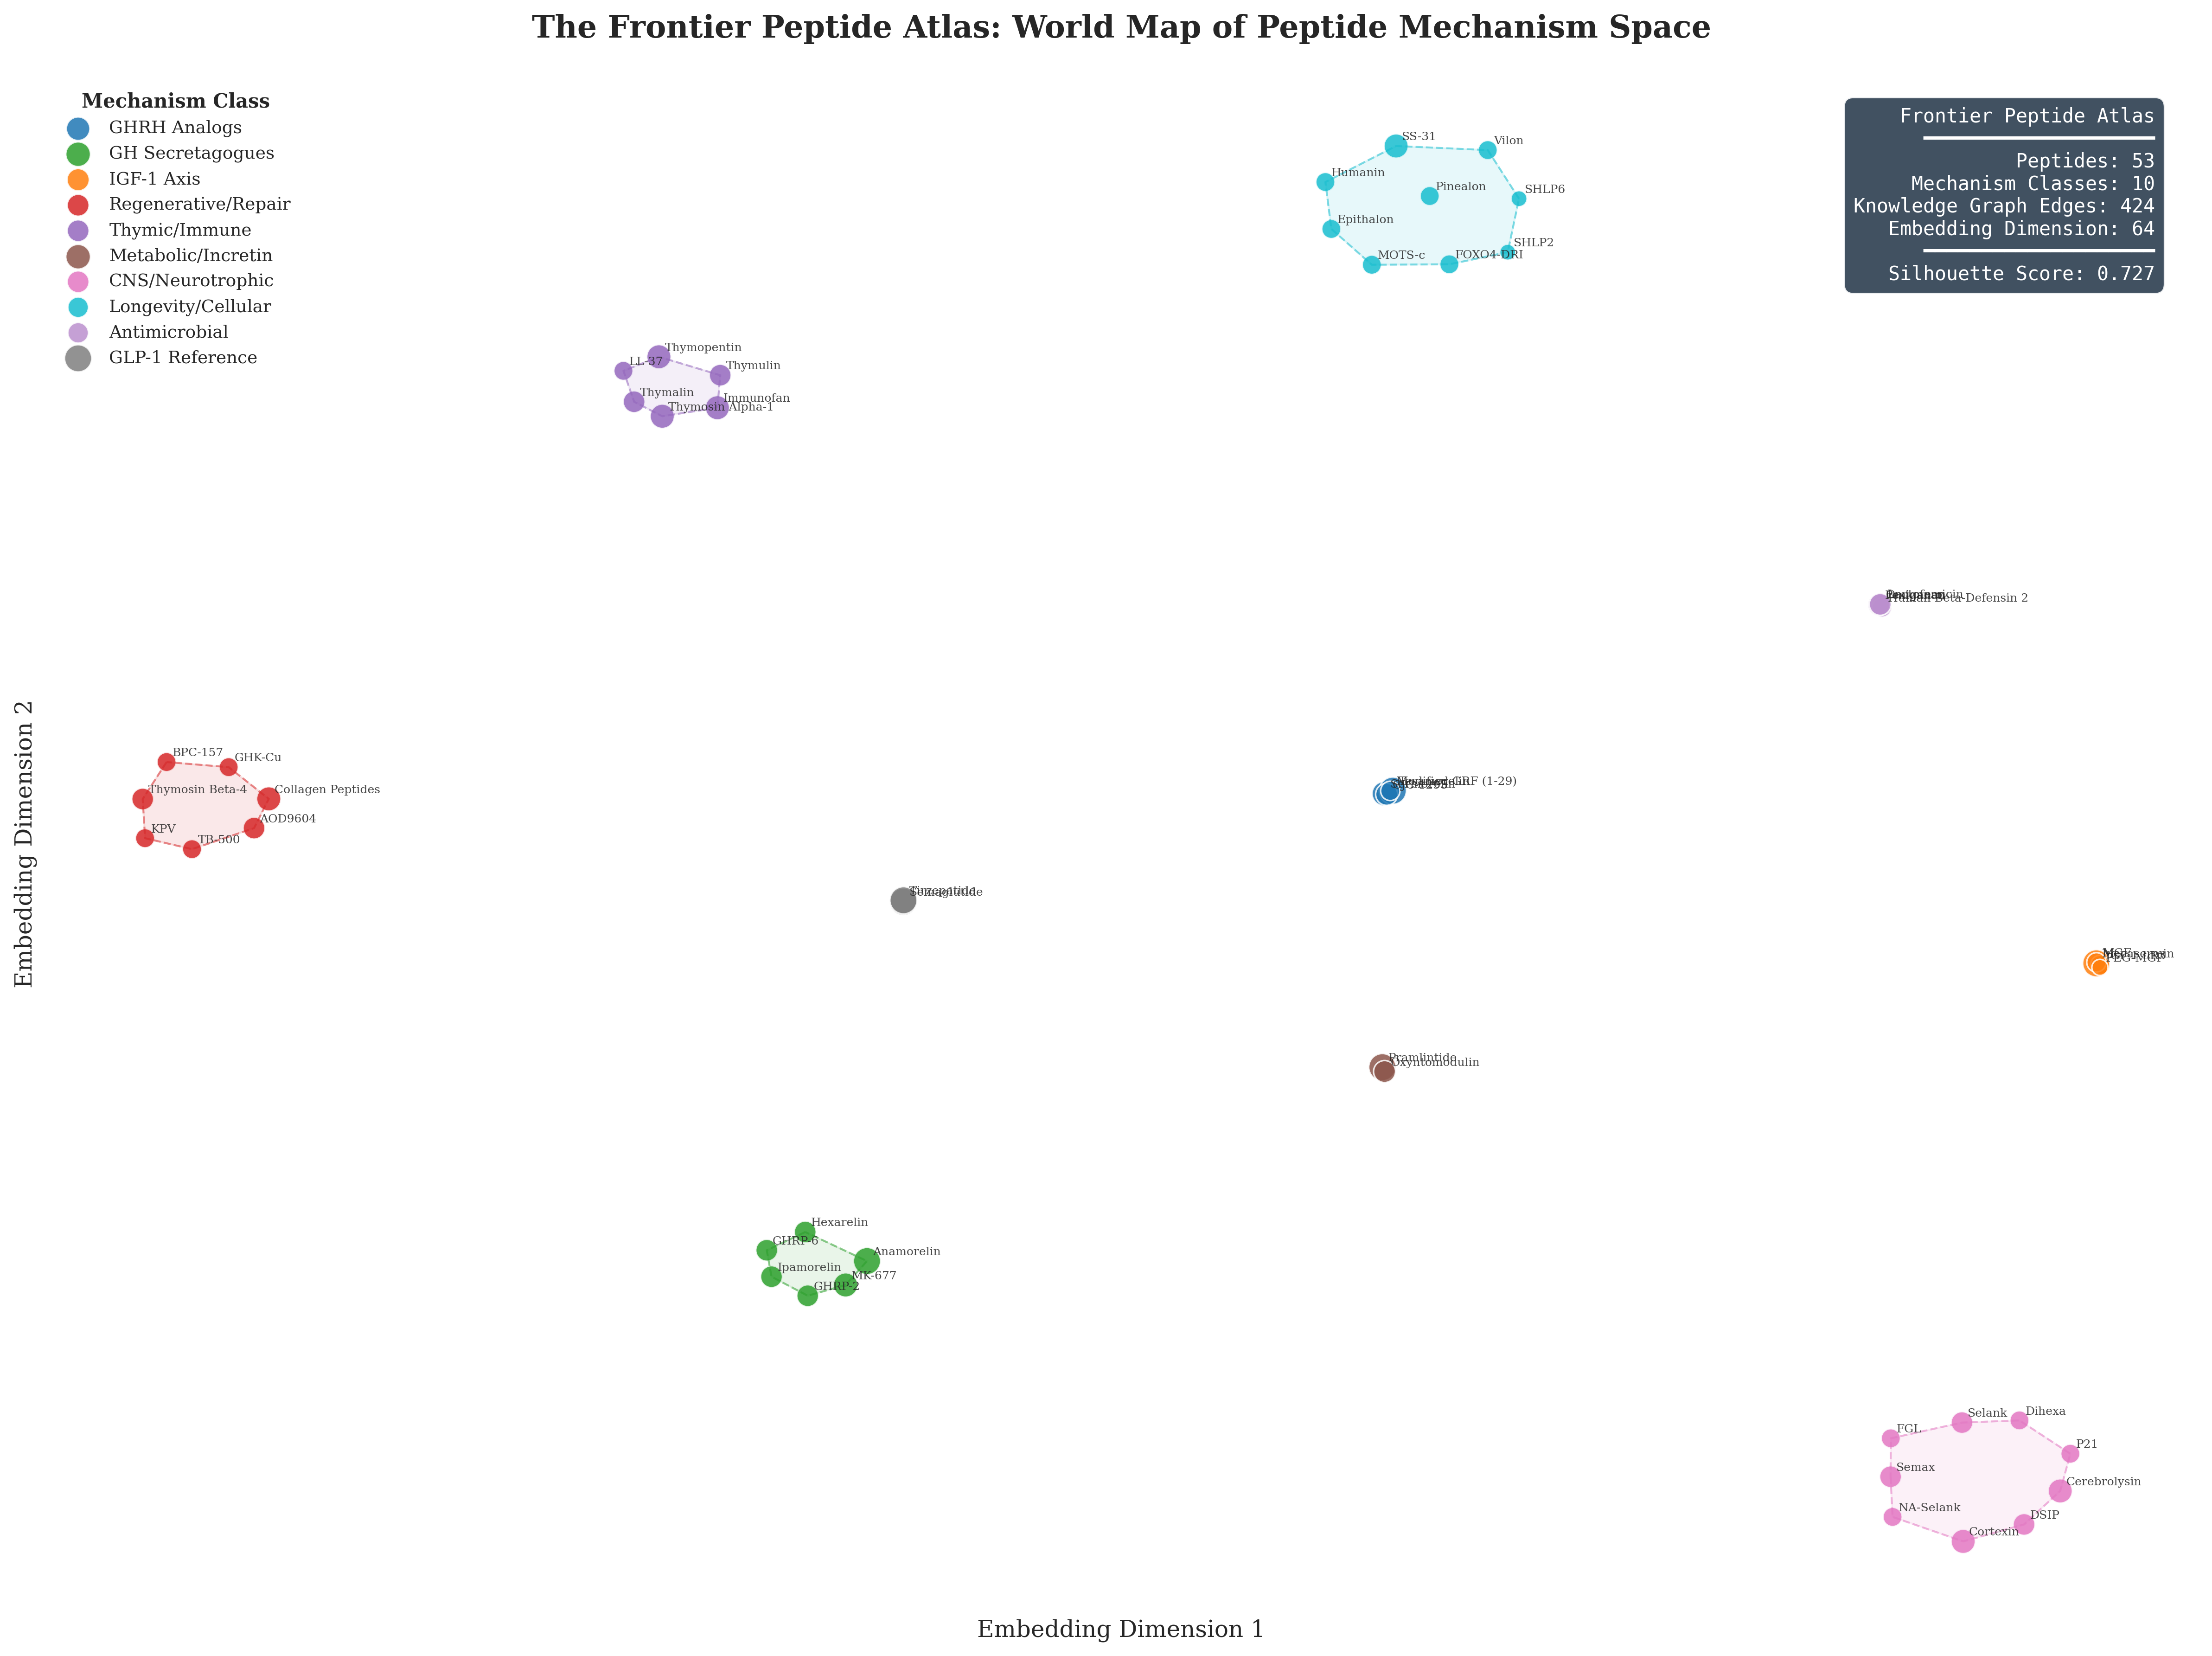

In [17]:
fig, ax = plt.subplots(figsize=(16, 12))

# Use t-SNE coordinates
x = embeddings_2d[:, 0]
y = embeddings_2d[:, 1]

# Size by evidence tier
sizes = [tier_to_size.get(t, 80) for t in evidence_tiers]

# Plot each class
for class_name in CLASS_COLORS.keys():
    mask = [c == class_name for c in peptide_classes]
    if sum(mask) == 0:
        continue
    
    ax.scatter(
        embeddings_2d[mask, 0], 
        embeddings_2d[mask, 1], 
        c=CLASS_COLORS[class_name], 
        s=[sizes[i] for i, m in enumerate(mask) if m],
        label=CLASS_NAMES[class_name], 
        alpha=0.85, 
        edgecolors='white', 
        linewidth=0.8
    )

# Label ALL peptides
for i, name in enumerate(peptide_names):
    ax.annotate(
        name, 
        (embeddings_2d[i, 0], embeddings_2d[i, 1]),
        xytext=(3, 3), 
        textcoords='offset points',
        fontsize=6, 
        alpha=0.85,
        fontweight='medium'
    )

# Draw convex hulls around clusters
from scipy.spatial import ConvexHull

for class_name in CLASS_COLORS.keys():
    mask = np.array([c == class_name for c in peptide_classes])
    if sum(mask) < 3:
        continue
    
    points = embeddings_2d[mask]
    try:
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        hull_points = np.vstack([hull_points, hull_points[0]])  # Close the hull
        ax.fill(hull_points[:, 0], hull_points[:, 1], 
                alpha=0.1, color=CLASS_COLORS[class_name])
        ax.plot(hull_points[:, 0], hull_points[:, 1], 
                '--', alpha=0.5, color=CLASS_COLORS[class_name], linewidth=1)
    except:
        pass

# Legend
legend = ax.legend(
    loc='upper left', 
    framealpha=0.95, 
    title='Mechanism Class',
    fontsize=9,
    title_fontsize=10
)
legend.get_title().set_fontweight('bold')

# Stats box
stats_text = f"""Frontier Peptide Atlas
━━━━━━━━━━━━━━━━━━━━
Peptides: {len(kg.peptides)}
Mechanism Classes: 10
Knowledge Graph Edges: {kg.edge_count}
Embedding Dimension: 64
━━━━━━━━━━━━━━━━━━━━
Silhouette Score: {sil_score:.3f}"""

ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right',
        fontfamily='monospace',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#2c3e50', edgecolor='white', alpha=0.9),
        color='white')

ax.set_xlabel('Embedding Dimension 1', fontsize=12)
ax.set_ylabel('Embedding Dimension 2', fontsize=12)
ax.set_title('The Frontier Peptide Atlas: World Map of Peptide Mechanism Space', 
             fontsize=16, fontweight='bold', pad=20)

# Remove axis for cleaner look
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig7_world_map.pdf', bbox_inches='tight', dpi=300)
plt.savefig(FIGURES_DIR / 'fig7_world_map.png', bbox_inches='tight', dpi=300)
print(f"Saved: {FIGURES_DIR / 'fig7_world_map.pdf'}")
plt.show()

---

## Summary

All figures have been generated and saved to the `figures/` directory.

In [18]:
# List all generated figures
print("\n" + "="*60)
print("GENERATED FIGURES")
print("="*60)

for fig_file in sorted(FIGURES_DIR.glob('*.pdf')):
    size_kb = fig_file.stat().st_size / 1024
    print(f"  {fig_file.name:<40} ({size_kb:.1f} KB)")

print("\n" + "="*60)
print("Copy the 'figures/' folder to your Overleaf project.")
print("="*60)


GENERATED FIGURES
  fig1_kg_schema.pdf                       (48.2 KB)
  fig2_rgat_architecture.pdf               (66.4 KB)
  fig3_tsne_embeddings.pdf                 (43.3 KB)
  fig4_mapper_graph.pdf                    (35.8 KB)
  fig5_persistence.pdf                     (33.2 KB)
  fig6_poincare_embeddings.pdf             (39.2 KB)
  fig7_world_map.pdf                       (56.3 KB)

Copy the 'figures/' folder to your Overleaf project.
